## imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from torch.utils.data import Dataset,DataLoader, random_split
import pandas as pd
from torch import nn
import shutil
import torch
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
import torch.nn.functional as F
import lightning as L
from torchmetrics import Accuracy
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score
from joblib import load, dump
from tqdm import tqdm
import neptune
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score, f1_score, confusion_matrix, log_loss
import seaborn as sns
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Preprocess

In [ ]:
!kaggle competitions download -c bgu-i-know-what-you-did-last-measurement-time

In [ ]:
!mkdir Original_Dataset
!unzip -q ./bgu-i-know-what-you-did-last-measurement-time -d ./Original_Dataset
!rm ./bgu-i-know-what-you-did-last-measurement-time

In [ ]:
directory = '/home/ronfay/deep_learning/hw2/Dataset/unlabeled/unlabeled'

In [ ]:
import os
import pandas as pd
from tqdm import tqdm

def preprocess(directory):
    # Get list of files in the directory
    files = os.listdir(directory)

    # Initialize tqdm with the total number of files
    progress_bar = tqdm(total=len(files), desc='Processing files')

    # Iterate over each file in the directory
    for filename in files:
        # Update tqdm progress bar
        progress_bar.update(1)

        # Check if the item is a file
        csv_path = os.path.join(directory, filename)
        if os.path.isfile(csv_path):
            csv_file = pd.read_csv(csv_path)
            x, y, z = type_df_columns(csv_file)
            if x == 'x':  # there is 'measurement type' column
                # Filter records where 'measurement type' is 'acceleration'
                csv_file = csv_file[csv_file['measurement type'] == 'acceleration [m/s/s]']
            while len(csv_file) < 4000:
                if len(csv_file) + 500 > 4000:
                    last_500_records = csv_file.tail(4000-len(csv_file))
                else:
                    last_500_records = csv_file.tail(500)
                csv_file = pd.concat([csv_file, last_500_records], ignore_index=True)
            csv_file.to_csv(csv_path, index=False)  # need to change when moving to jupyter
    # Close tqdm progress bar
    progress_bar.close()

preprocess(directory)  # change to unlabel directory path


Processing files: 100%|██████████| 124992/124992 [1:23:48<00:00, 24.86it/s] 


In [ ]:
def create_small_test_df(unlabeled_dir_path, test_csv_path):
    df_sample = pd.read_csv(test_csv_path)
    df_test = pd.DataFrame(columns=df_sample.columns)
    df_test = df_test.rename(columns={'sample_id': 'ID'})
    df_test['ID'] = df_sample['sample_id'].iloc[:80]
    df_test['file_path'] = None

    for index, row in df_sample.iloc[:80].iterrows():
        csv_path = f"{unlabeled_dir_path}/{int(row['sample_id'])}.csv"
        df_test.at[index, 'file_path'] = csv_path
    return df_test

In [ ]:
def create_test_df(unlabeled_dir_path, test_csv_path):
    df_sample = pd.read_csv(test_csv_path)
    df_test = pd.DataFrame(columns=df_sample.columns)
    df_test = df_test.rename(columns={'sample_id': 'ID'})
    df_test['ID'] = df_sample['sample_id']
    df_test['file_path'] = None

    for index, row in df_sample.iterrows():
        csv_path = f"{unlabeled_dir_path}/{int(row['sample_id'])}.csv"
        df_test.at[index, 'file_path'] = csv_path
    return df_test

In [ ]:
def create_big_df(unlabeled_dir_path, train_csv_path):
    df = pd.DataFrame(columns=['ID', 'file_path', 'Label','userid'])
    train_csv = pd.read_csv(train_csv_path)
    for index, row in train_csv.iterrows():
        label = row['activity']
        id = row['id']
        csv_path = f"{unlabeled_dir_path}/{id}.csv"
        user_id = row['userid']
        new_row = {'ID': id, 'file_path': csv_path, 'Label': label,'userid': user_id}
        df.loc[len(df)] = new_row
    return df

In [ ]:
def create_small_df(unlabeled_dir_path, train_csv_path):
    df = pd.DataFrame(columns=['ID', 'file_path', 'Label','userid'])
    train_csv = pd.read_csv(train_csv_path)
    user_id_count = {}
    for index, row in train_csv.iterrows():
        # little data:
        label = row['activity']
        id = row['id']
        csv_path = f"{unlabeled_dir_path}/{id}.csv"
        user_id = row['userid']
        if user_id in user_id_count:
            if user_id_count[user_id] < 5:
                new_row = {'ID': id, 'file_path': csv_path, 'Label': label, 'userid' : user_id}
                df.loc[len(df)] = new_row
                user_id_count[user_id] +=1
        else:
            user_id_count[user_id] = 1
            new_row = {'ID': id, 'file_path': csv_path, 'Label': label,'userid' : user_id}
            df.loc[len(df)] = new_row
    return df

In [ ]:
train_path = '/home/ronfay/deep_learning/hw2/Dataset/train.csv'
train_csv_df = pd.read_csv(train_path)

In [ ]:
train_big_df = create_big_df(directory, train_path)
train_big_df.to_csv("train_big_df.csv")

In [ ]:
train_big_df = pd.read_csv("train_big_df.csv")

In [ ]:
sample_path = "sample_submission.csv"
df_sample = pd.read_csv(sample_path)

In [ ]:
# test_df would have columns like in sample submission
# and file_name, and sample_id -> ID
test_df = create_test_df(directory,test_path)
test_df.to_csv("test_df.csv")

In [ ]:
test_df = pd.read_csv("test_df.csv")

## Helpers

In [ ]:
def type_df_columns(df_xyz):
    if 'measurement type' in df_xyz.columns:
        filtered_data = df_xyz[df_xyz['measurement type'] == 'acceleration [m/s/s]']
        x = 'x'
        y = 'y'
        z = 'z'
    else:
        filtered_data = df_xyz
        x = 'x [m]'
        y = 'y [m]'
        z = 'z [m]'
    return x, y, z

In [ ]:
def remove_unnamed_cols(df):
    unnamed_cols = [col for col in df.columns if col.startswith("Unnamed")]
    # If there are any such columns, remove them from the DataFrame
    if unnamed_cols:
        df.drop(columns=unnamed_cols, inplace=True)

In [ ]:
def valid_df(df):
    # Check if the columns are the same
    columns_equal = df.columns.equals(df_sample.columns)
    # Check if the columns are the same and in the same order
    columns_and_order_equal = list(df.columns) == list(df_sample.columns)
    if not columns_and_order_equal:
        print("The columns or their order differ between the two DataFrames.")
    column_name = 'sample_id'
    # Check if the values in the column are the same in both DataFrames
    values_equal = df.reset_index(drop=True)[column_name].equals(df_sample.reset_index(drop=True)[column_name])
    if not values_equal:
        print(f"The values in column '{column_name}' differ between the two DataFrames.")
    missing_values = df.isna().sum()
    if not missing_values.sum() == 0:
        print("DataFrame contains missing values.")

    df_filtered = df.drop(columns=['sample_id'])

    # Check the sum of values in each row
    row_sums = df_filtered.sum(axis=1)
    rows_with_sum_not_1 = df[~(row_sums == 1)]
    if len(rows_with_sum_not_1)>0:
        # Print the rows
        print("Rows where the sum of values is not 1:")
        print(rows_with_sum_not_1)
        # Filter rows where the sum of values is not 1

    # Filter rows where not all values are between 0 and 1
    rows_with_values_not_between_0_1 = df_filtered[~((df_filtered >= 0) & (df_filtered <= 1)).all(axis=1)]
    if len(rows_with_values_not_between_0_1)>0:
        print("\nRows where not all values are between 0 and 1:")
        print(rows_with_values_not_between_0_1)


In [ ]:
# files with empty rows
empty_rows_files = [81874,81875,81876,81903, 81904, 81905, 81931, 81932, 81933, 81964,81965,81966,81967,81998,81999,82000,82030,82031,82032]
print(len(empty_rows_files))

In [ ]:
# fill empty values of inputs in Dataset
for file in empty_rows_files:
    file_path = f"{directory}/{file}.csv"
    df_temp = pd.read_csv(file_path)
    df_temp_filled = df_temp.fillna(method='ffill')
    df_temp_filled.to_csv(file_path)

# **Q1 - Data Analysis**

In [ ]:
# Plot feature distribution of the data
def plot_features(train_df, feature):
    feature_counts = train_df[feature].value_counts()
    counts = feature_counts.values
    mean_count = np.mean(counts)
    std_dev = np.std(counts)
    print("mean count: ", mean_count)
    print("std_dev: ", std_dev)

    # Calculate the range for highlighting values outside 1 standard deviation
    lower_bound = mean_count - std_dev
    upper_bound = mean_count + std_dev

    # Create a bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(np.arange(len(feature_counts)), counts, color='blue', label='Counts')
    plt.xticks(np.arange(len(feature_counts)), feature_counts.index, rotation=45)

    # Highlight values outside 1 standard deviation in red
    red_labels = [label for label, count in feature_counts.items() if count < lower_bound or count > upper_bound]
    plt.bar([feature_counts.index.get_loc(label) for label in red_labels],
            [count for count in counts if count < lower_bound or count > upper_bound],
            color='red', label='Outside 1 Std Dev')

    plt.ylabel('Count')
    plt.legend()
    plt.tight_layout()
    plt.show()
    print(f"Number of values outside 1 Std Dev: {len(red_labels)}")


mean count:  2791.5555555555557
std_dev:  1257.5349883456843


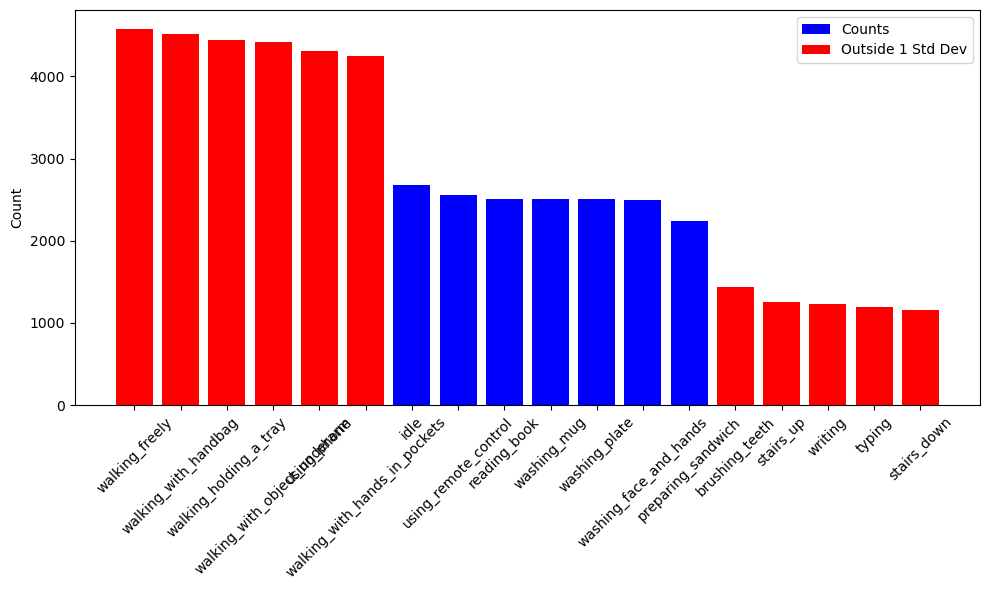

Number of values outside 1 Std Dev: 11


In [ ]:
plot_features(train_csv_df, 'activity')

mean count:  6281.0
std_dev:  510.87229323970973


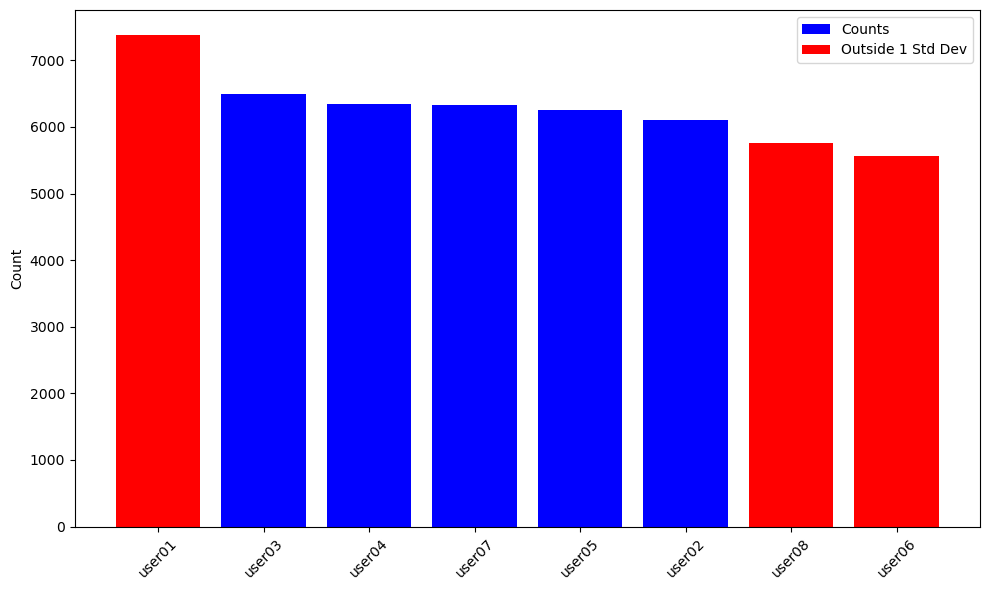

Number of values outside 1 Std Dev: 3


In [ ]:
plot_features(train_csv_df, 'userid')

mean count:  25124.0
std_dev:  17972.0


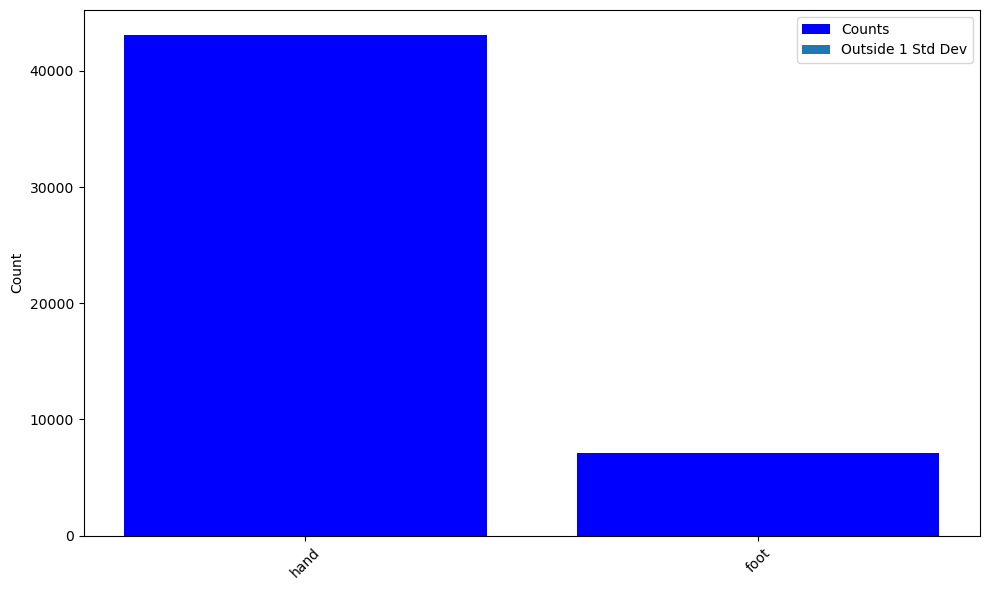

Number of values outside 1 Std Dev: 0


In [ ]:
plot_features(train_csv_df, 'body_part')

In [ ]:
# Plot users distribution of specific feature in the data
def plot_user(df, feature):
    # Create an empty DataFrame to hold aggregated information for each user
    user_summary_df = pd.DataFrame(columns=['user_id', f'{feature}_counts'])

    unique_user_ids = df['userid'].unique()
    # Initialize an empty list to store DataFrames
    user_summary_df_list = []

    for user_id in unique_user_ids:
        user_df = df[df['userid'] == user_id]
        feature_counts = user_df[feature].value_counts()
        user_summary = pd.DataFrame({'user_id': [user_id], f'{feature}_counts': [feature_counts]})
        user_summary_df_list.append(user_summary)

    user_summary_df = pd.concat(user_summary_df_list, ignore_index=True)

    # Calculate number of rows and columns for subplots
    num_plots = len(user_summary_df)
    num_cols = min(num_plots, 3)  # Maximum of 3 plots per row
    num_rows = -(-num_plots // num_cols)  # Ceiling division

    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

    # Plot for each user the distribution of the feature
    for i, (index, row) in enumerate(user_summary_df.iterrows()):
        user_id = row['user_id']
        feature_counts = row[f'{feature}_counts']

        # Select the subplot
        if num_rows > 1:
            ax = axes[i // num_cols, i % num_cols]
        else:
            ax = axes[i % num_cols]

        # Plot the bar chart
        ax.bar(feature_counts.index, feature_counts.values)
        ax.set_title(f'{feature} distribution for User {user_id}')
        ax.set_xlabel(f'{feature}')
        ax.set_ylabel('Count')
        ax.tick_params(axis='x', rotation=45)

    # Remove any unused subplots
    for j in range(num_plots, num_rows * num_cols):
        if num_rows > 1:
            fig.delaxes(axes[j // num_cols, j % num_cols])
        else:
            fig.delaxes(axes[j % num_cols])

    fig.tight_layout()
    plt.show()
    fig.savefig(f'users_{feature}_distribution.png')

In [ ]:
def plot_activity(df,activity):
    random_row = df.sample()
    file_name = random_row['id'].iloc[0]
    df_xyz = pd.read_csv(f"{directory}/{file_name}.csv")
    x, y, z = type_df_columns(df_xyz)
    # Plot data
    plt.plot(df_xyz[x], label='X')
    plt.plot(df_xyz[y], label='Y')
    plt.plot(df_xyz[z], label='Z')

    # Add labels, title, and legend
    plt.xlabel('Index')
    plt.ylabel('Acceleration [m/s/s]')
    plt.title(activity)
    plt.legend()
    plt.show()

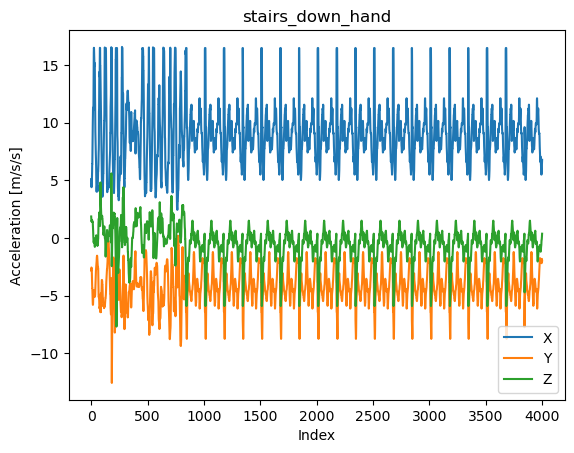

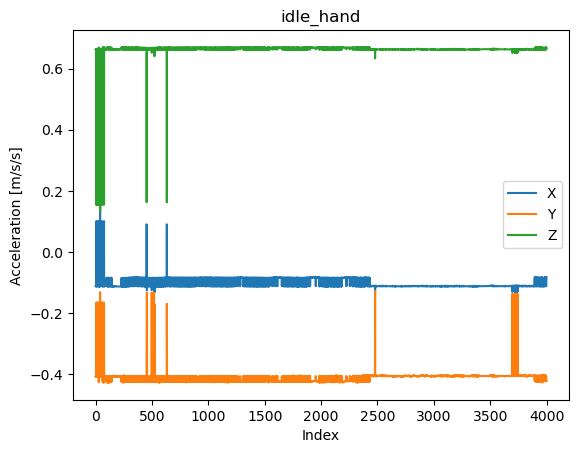

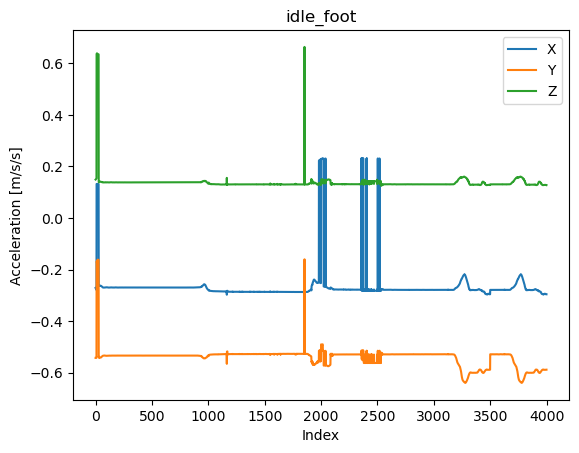

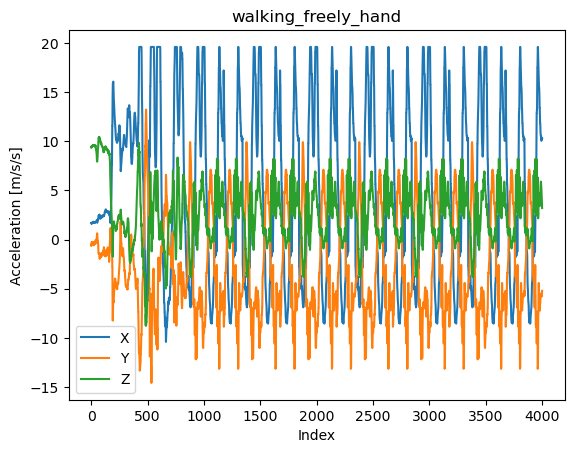

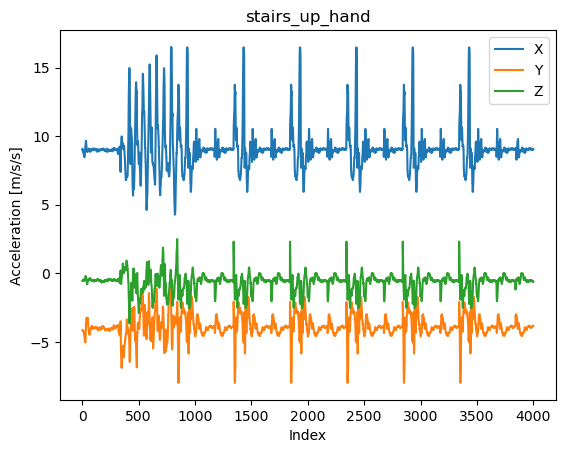

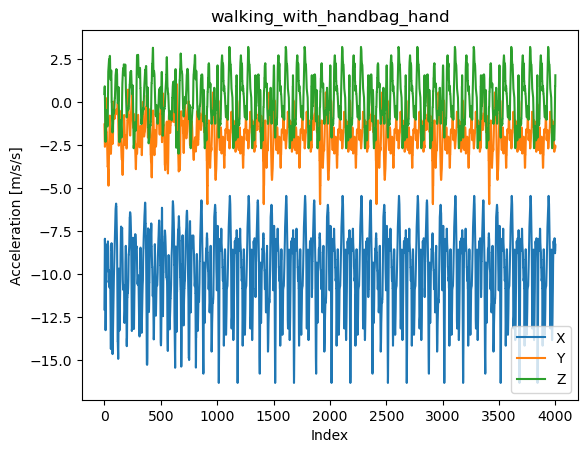

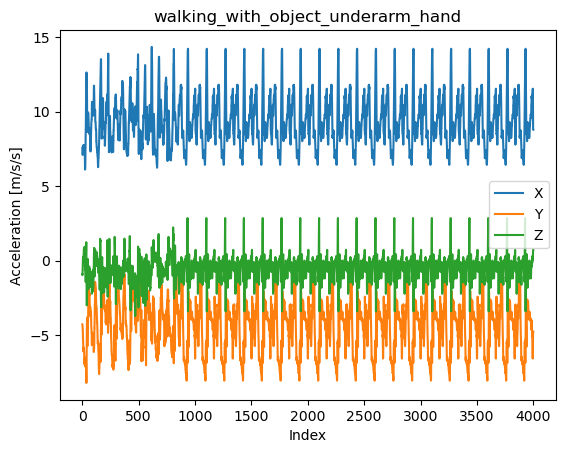

In [ ]:
stairs_down_hand = train_csv_df[(train_csv_df['activity'] == 'stairs_down') & (train_csv_df['body_part'] == 'hand')]
stairs_down_foot = train_csv_df[(train_csv_df['activity'] == 'stairs_up') & (train_csv_df['body_part'] == 'foot')]

idle_hand = train_csv_df[(train_csv_df['activity'] == 'idle') & (train_csv_df['body_part'] == 'hand')]
idle_foot = train_csv_df[(train_csv_df['activity'] == 'idle') & (train_csv_df['body_part'] == 'foot')]

walking_freely_hand = train_csv_df[(train_csv_df['activity'] == 'walking_freely') & (train_csv_df['body_part'] == 'hand')]
walking_freely_foot = train_csv_df[(train_csv_df['activity'] == 'walking_freely') & (train_csv_df['body_part'] == 'foot')]

stairs_up_hand = train_csv_df[(train_csv_df['activity'] == 'stairs_up') & (train_csv_df['body_part'] == 'hand')]

walking_handbag = train_csv_df[(train_csv_df['activity'] == 'walking_with_handbag') & (train_csv_df['body_part'] == 'hand')]

walking_with_object_underarm = train_csv_df[(train_csv_df['activity'] == 'walking_with_object_underarm') & (train_csv_df['body_part'] == 'hand')]

plot_activity(stairs_down_hand, "stairs_down_hand") # no foot
plot_activity(idle_hand, "idle_hand")
plot_activity(idle_foot, "idle_foot")
plot_activity(walking_freely_hand, "walking_freely_hand")
plot_activity(stairs_up_hand, "stairs_up_hand")
plot_activity(walking_handbag, "walking_with_handbag_hand")
plot_activity(walking_with_object_underarm, "walking_with_object_underarm_hand")

In [ ]:
# Plot good and bad classifications
def plot_classification(id):
    df_xyz = pd.read_csv(f"{directory}/{id}.csv")
    x, y, z = type_df_columns(df_xyz)
    # Plot data
    plt.plot(df_xyz[x], label='X')
    plt.plot(df_xyz[y], label='Y')
    plt.plot(df_xyz[z], label='Z')

    # Add labels, title, and legend
    plt.xlabel('Index')
    plt.ylabel('Acceleration [m/s/s]')
    plt.title(train_df[train_df['ID']==id]['Label'])
    plt.legend()
    plt.show()

Good and bad classifications of CNN

good:


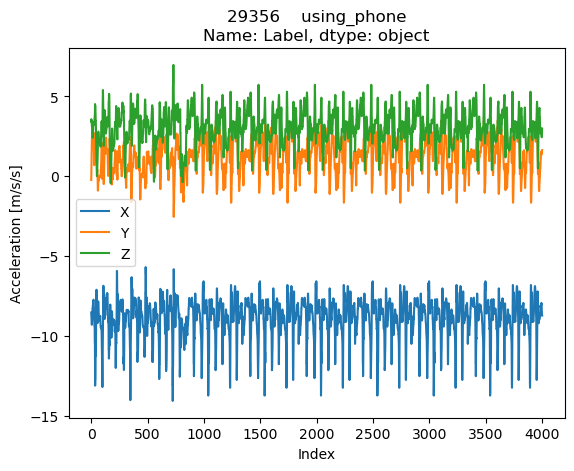

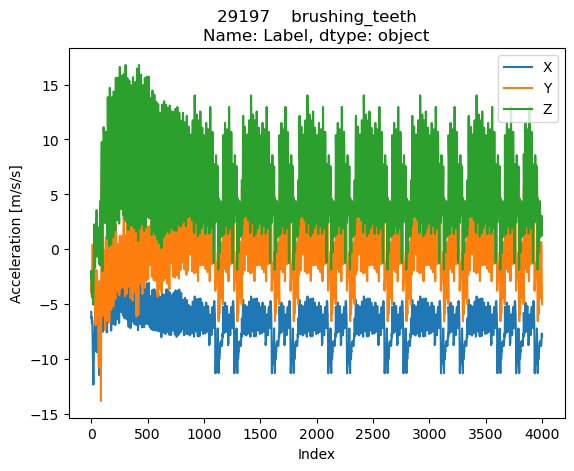

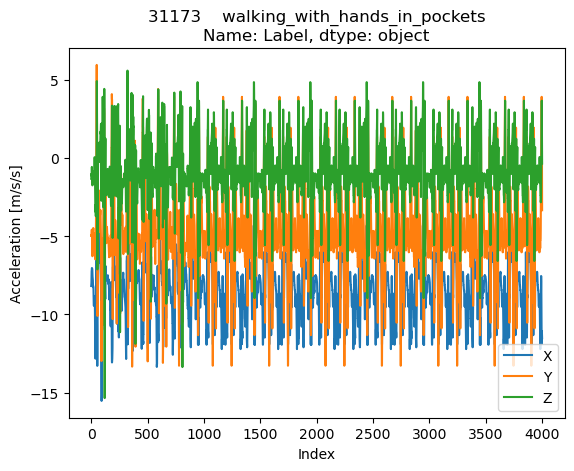

bad:


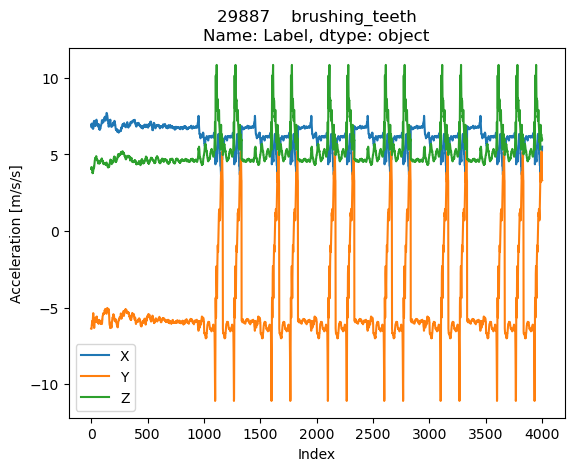

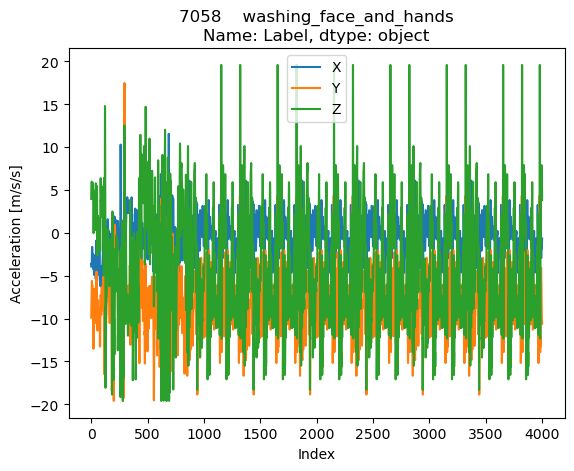

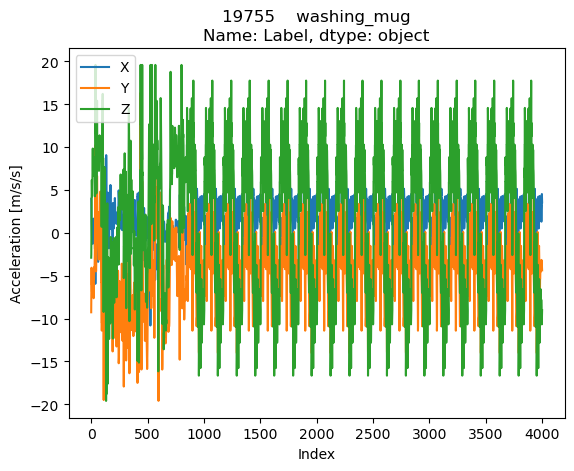

uncertain true:


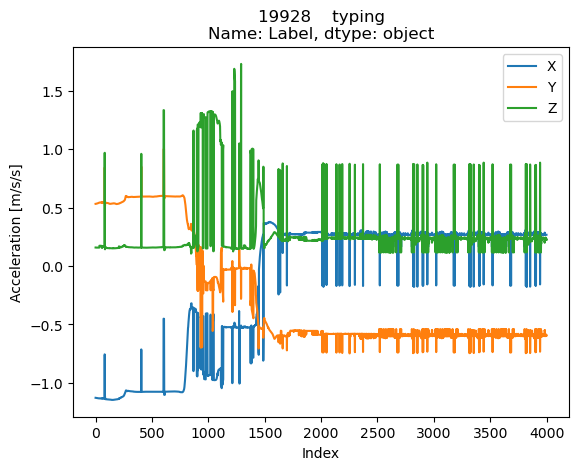

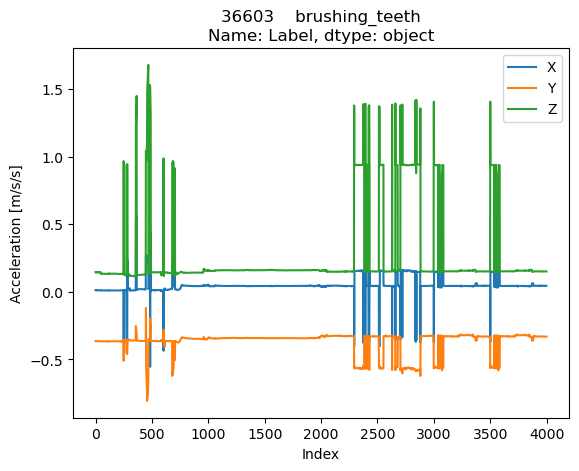

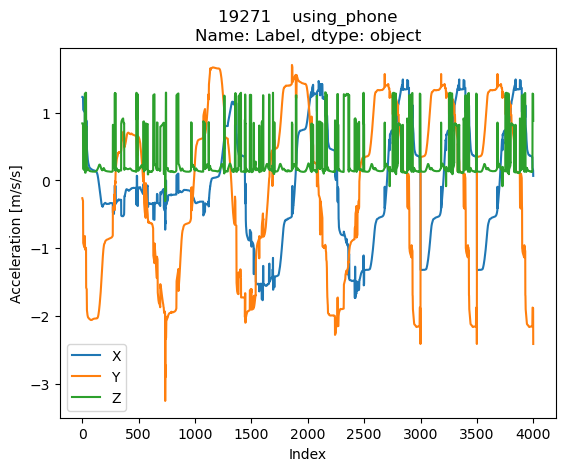

uncertain:


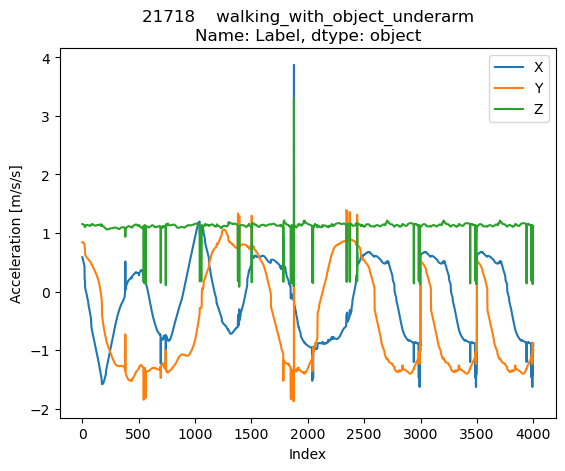

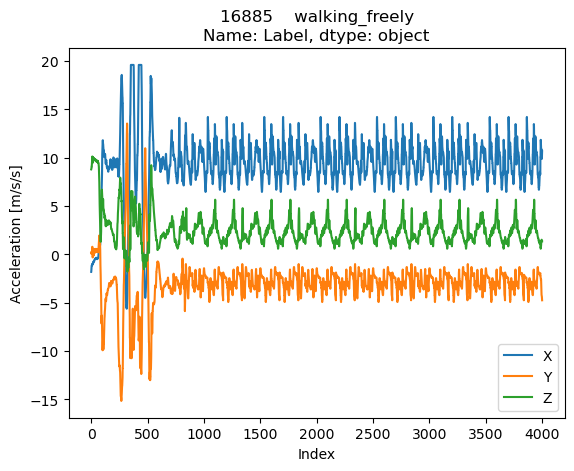

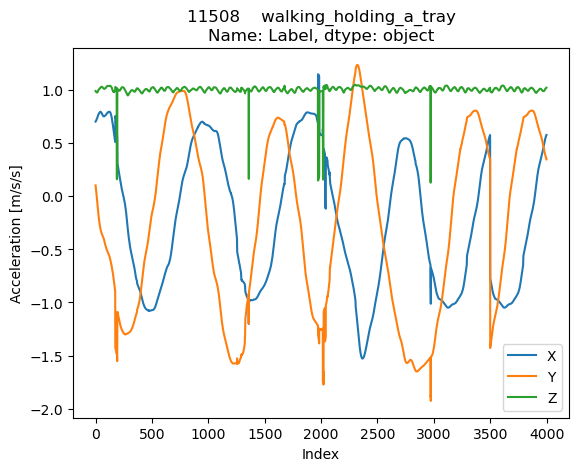

In [ ]:
print("good:")
plot_classification(23591)
plot_classification(20933)
plot_classification(37147)
print("bad:")
plot_classification(58921)
plot_classification(38871)
plot_classification(10242)
print("uncertain true:")
plot_classification(23016)
plot_classification(31042)
plot_classification(5133)
print("uncertain:")
plot_classification(28729)
plot_classification(15153)
plot_classification(7455)

LSTM classification:

good:


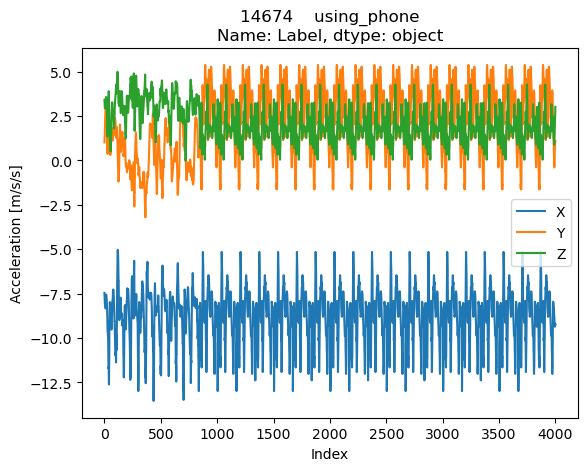

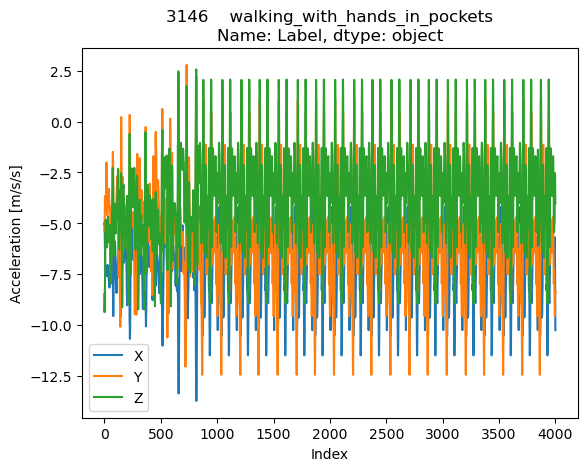

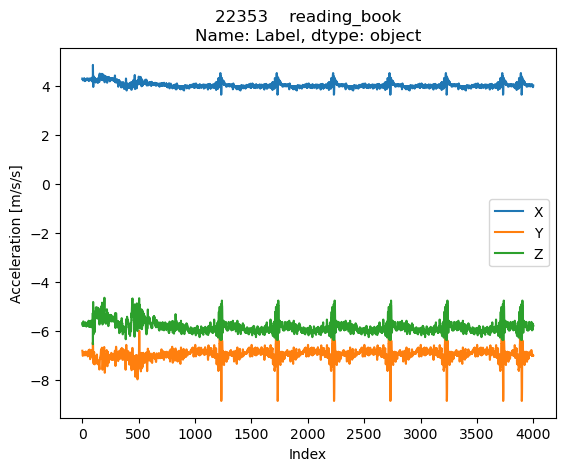

bad:


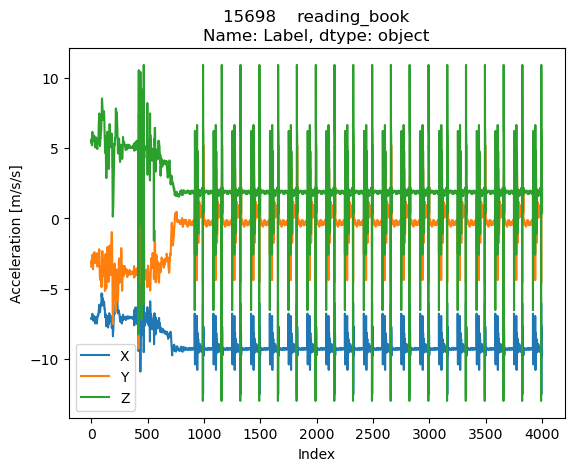

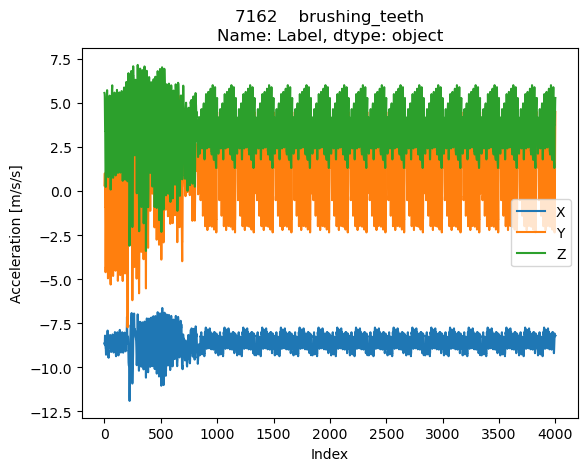

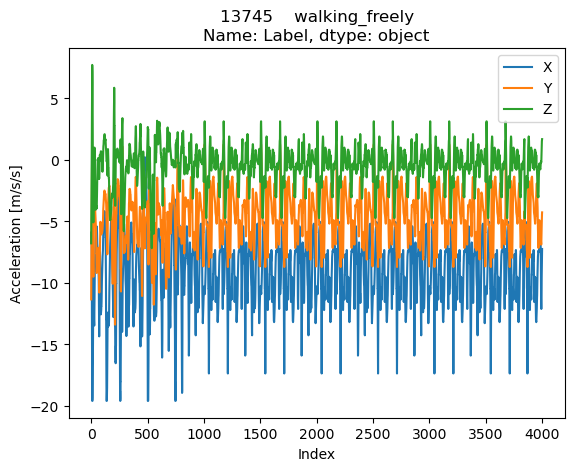

uncertain true:


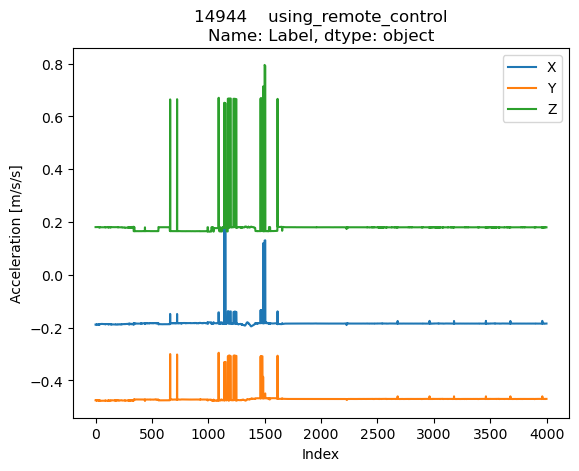

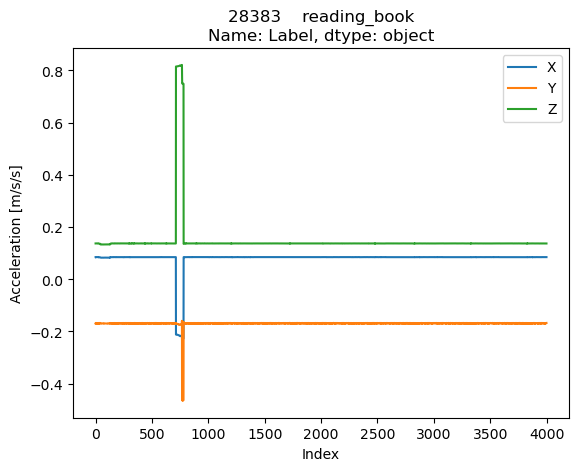

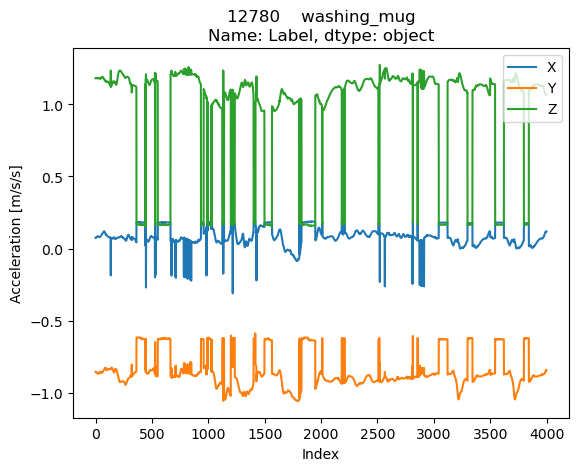

uncertain:


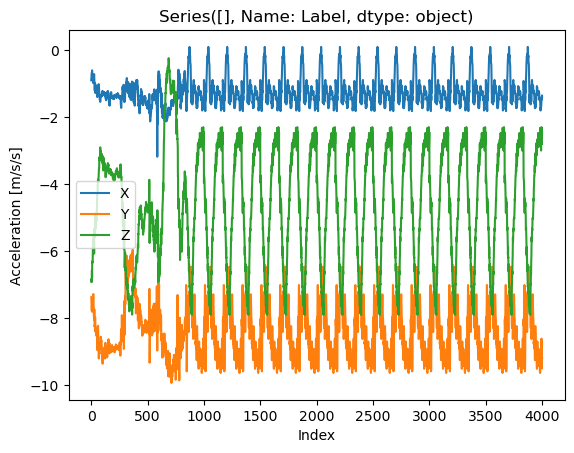

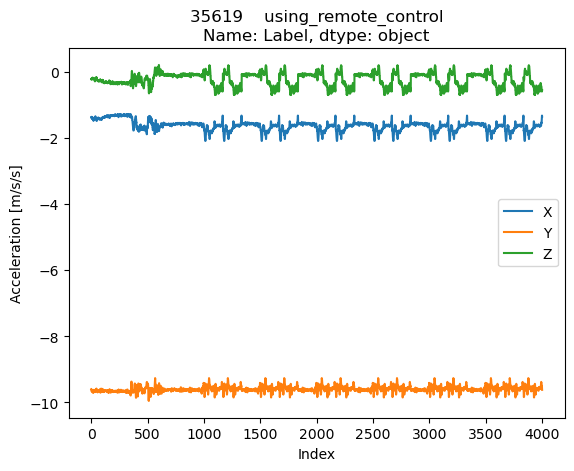

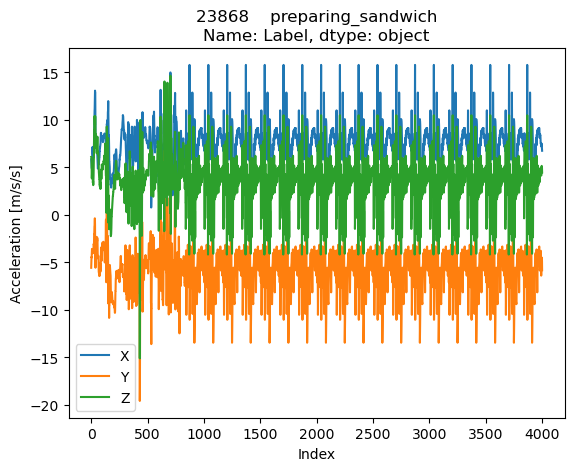

In [ ]:
print("good:")
plot_classification(4921)
plot_classification(46832)
plot_classification(1186)
print("bad:")
plot_classification(22577)
plot_classification(20909)
plot_classification(24621)
print("uncertain true:")
plot_classification(14694)
plot_classification(60527)
plot_classification(29777)
print("uncertain:")
plot_classification(51331)
plot_classification(61926)
plot_classification(31792)

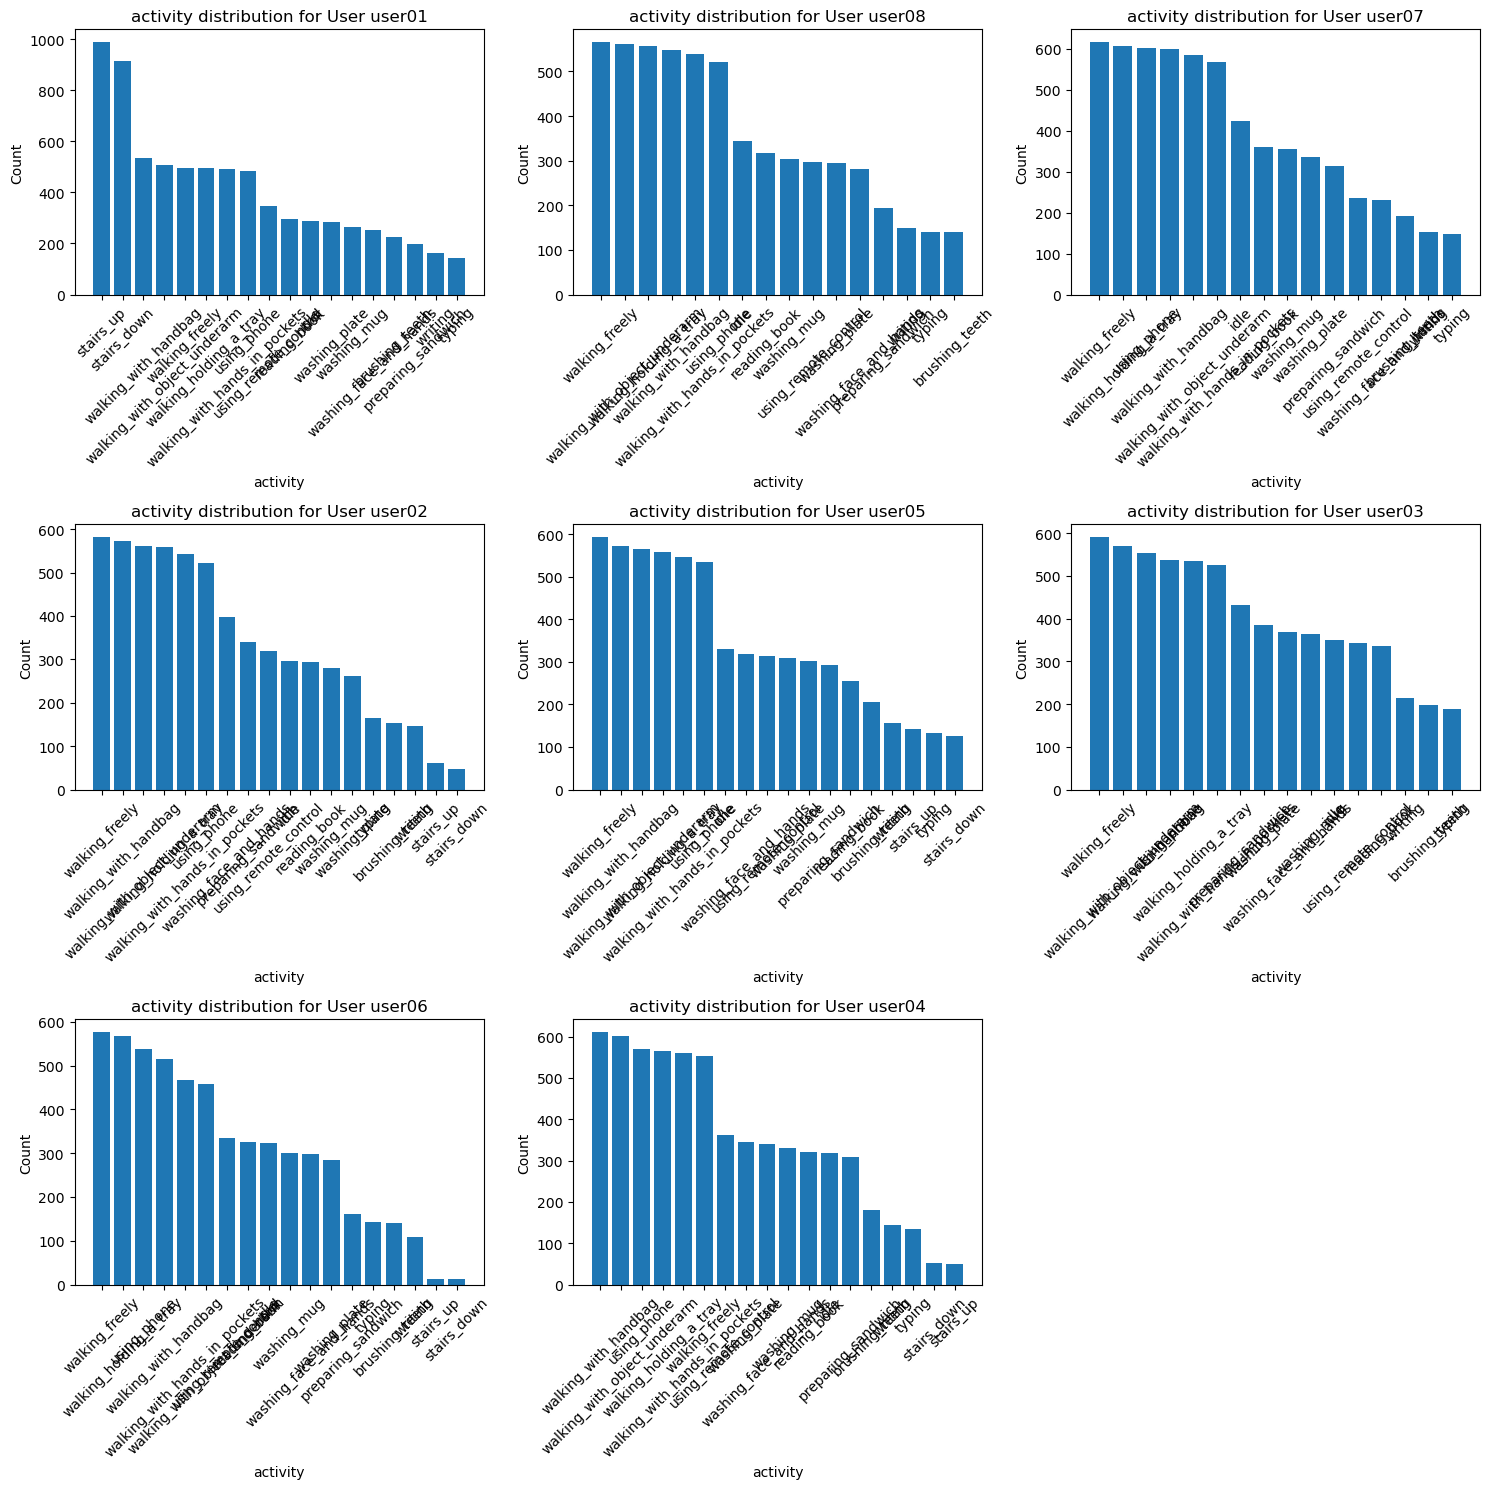

In [ ]:
plot_user(train_csv_df, 'activity')

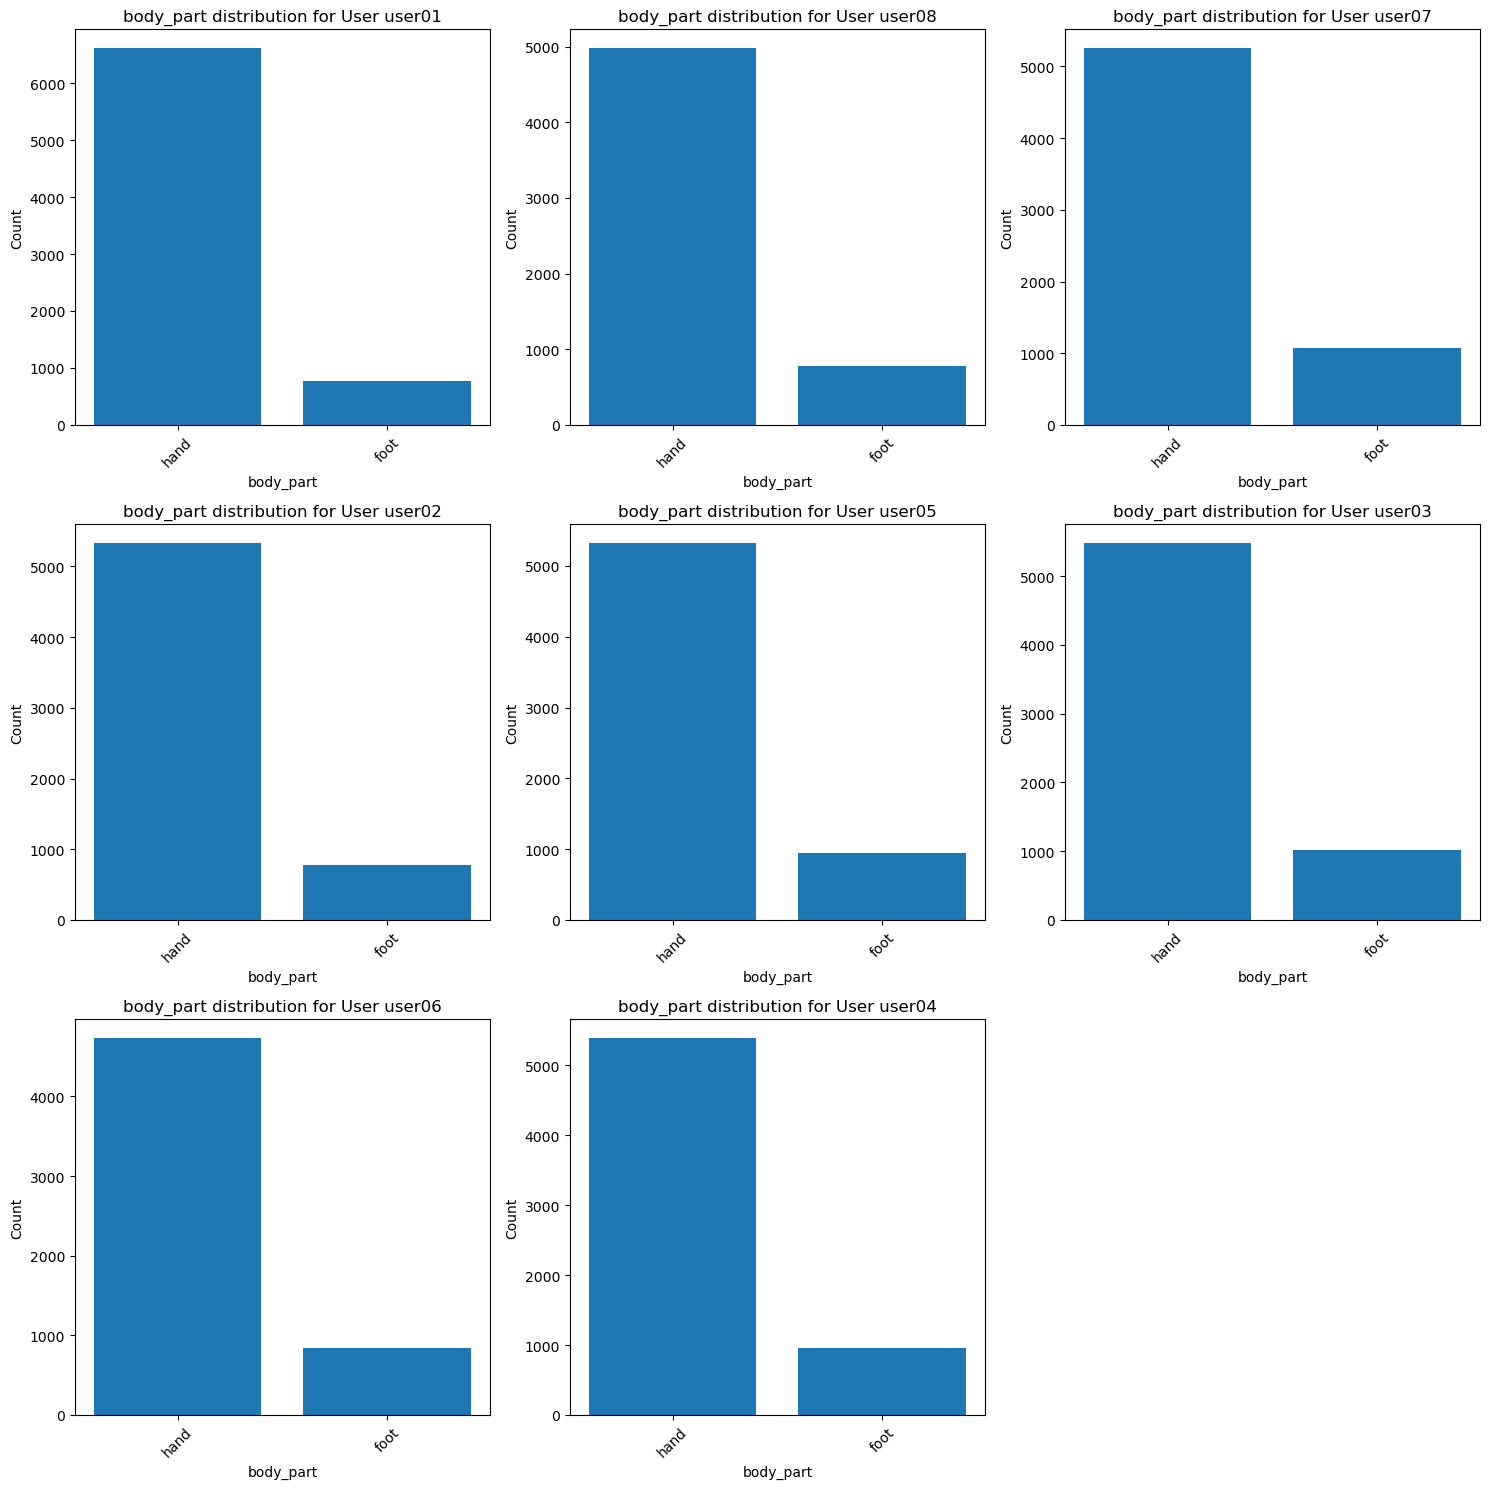

In [ ]:
plot_user(train_csv_df, 'body_part')

# **Q2 - Neural Network**

## Q2.a - Validation Strategy

In [ ]:
# Filter out records for users 6 and 8 for the validation dataframe
val_df = train_big_df[(train_big_df['userid'] == 'user06') | (train_big_df['userid'] == 'user08')].reset_index(drop=True)
train_df = train_big_df[(train_big_df['userid'] != 'user06') & (train_big_df['userid'] != 'user08')].reset_index(drop=True)

In [ ]:
remove_unnamed_cols(train_df)
remove_unnamed_cols(val_df)
remove_unnamed_cols(test_df)

## Naïve Baseline Solution

In [ ]:
# Create Naive solution using the distribution of the labels in the data
class_distribution = train_df['Label'].value_counts(normalize=True)
y_pred_class_distribution_train = np.random.choice(class_distribution.index, size=len(train_df), p=class_distribution.values)
y_pred_class_distribution_val = np.random.choice(class_distribution.index, size=len(val_df), p=class_distribution.values)

accuracy_class_distribution_train = accuracy_score(train_df['Label'], y_pred_class_distribution_train)
accuracy_class_distribution_val = accuracy_score(val_df['Label'], y_pred_class_distribution_val)

print(f"Train Class Distribution Accuracy: {accuracy_class_distribution_train:.2f}")
print(f"Validation Class Distribution Accuracy: {accuracy_class_distribution_val:.2f}")

Train Class Distribution Accuracy: 0.06
Validation Class Distribution Accuracy: 0.07


## Q2.c - Machine Learning model

In [ ]:
def calculate_df_ML_and_calculate_features_not_test(df):
    # Initialize an empty DataFrame to store the calculated features
    new_df = pd.DataFrame()

    # Iterate over the rows in the DataFrame
    for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing rows"):
        csv_path = row['file_path']
        chunk_df = pd.read_csv(csv_path)
        # Initialize an empty dictionary to store calculated features
        features = {}

        # Calculate statistics for each axis (x, y, z) in chunks of 100 records
        for i in range(0, len(chunk_df), 100):
            x,y,z = type_df_columns(chunk_df)
            chunk = chunk_df.iloc[i:i+100]  # Select a chunk of 100 records
            # Calculate statistics for each axis
            for axis in [x, y, z]:
                axis_data = chunk[axis]
                features[f'mean_{axis[0]}_{i}'] = axis_data.mean()
                features[f'std_{axis[0]}_{i}'] = axis_data.std()
                features[f'min_{axis[0]}_{i}'] = axis_data.min()
                features[f'var_{axis[0]}_{i}'] = axis_data.var()
                features[f'max_{axis[0]}_{i}'] = axis_data.max()
                features[f'median_{axis[0]}_{i}'] = axis_data.median()

        # Create a DataFrame from the calculated features
        features['Label'] = row['Label']
        features['file_path'] = row['file_path']
        features['ID'] = row['ID']
        features_df = pd.DataFrame(features, index=[0])

        # Concatenate the new DataFrame with the existing DataFrame
        new_df = pd.concat([new_df, features_df], ignore_index=True)

    return new_df

In [ ]:
def calculate_df_ML_and_calculate_features_test(df, save_every=500, save_path='output.csv'):
    # Initialize an empty DataFrame to store the calculated features
    new_df = pd.DataFrame()

    # Iterate over the rows in the DataFrame
    for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing rows"):
        csv_path = row['file_path']
        chunk_df = pd.read_csv(csv_path)
        # Initialize an empty dictionary to store calculated features
        features = {}

        # Calculate statistics for each axis (x, y, z) in chunks of 100 records
        for i in range(0, len(chunk_df), 100):
            x,y,z = type_df_columns(chunk_df)
            chunk = chunk_df.iloc[i:i+100]  # Select a chunk of 100 records
            # Calculate statistics for each axis
            for axis in [x, y, z]:
                axis_data = chunk[axis]
                features[f'mean_{axis[0]}_{i}'] = axis_data.mean()
                features[f'std_{axis[0]}_{i}'] = axis_data.std()
                features[f'min_{axis[0]}_{i}'] = axis_data.min()
                features[f'var_{axis[0]}_{i}'] = axis_data.var()
                features[f'max_{axis[0]}_{i}'] = axis_data.max()
                features[f'median_{axis[0]}_{i}'] = axis_data.median()

        features['ID'] = row['ID']
        # Create a DataFrame from the calculated features
        features_df = pd.DataFrame(features, index=[0])
        # Concatenate features_df with new_df
        new_df = pd.concat([new_df, features_df], ignore_index=True)

        # Save the new_df DataFrame to a CSV file every save_every iterations
        if len(new_df) % save_every == 0:
            new_df.to_csv(save_path, index=False, mode='a', header=not os.path.exists(save_path))

    # Save any remaining data in new_df to the CSV file
    if not new_df.empty:
        new_df.to_csv(save_path, index=False, mode='a', header=not os.path.exists(save_path))

    return new_df


In [ ]:
train_df_ML = calculate_df_ML_and_calculate_features_not_test(train_df)
val_df_ML = calculate_df_ML_and_calculate_features_not_test(val_df)
train_df_ML.to_csv("train_df_ML_my.csv")
val_df_ML.to_csv("val_df_ML_my.csv")

In [ ]:
train_df_ML = pd.read_csv("train_df_ML.csv")
remove_unnamed_cols(train_df_ML)
val_df_ML = pd.read_csv("val_df_ML.csv")
remove_unnamed_cols(val_df_ML)

In [ ]:
# The running was to long so we splitted the df to parts
for i in range(0, 70000, 10000):
    test_df_ML = calculate_df_ML_and_calculate_features_test(test_df.iloc[i:i+10000], save_path=f'test_df_ML_{i}-{i+10000}.csv')
    test_df_ML.to_csv(f"test_df_ML_{i}-{i+10000}.csv")

Processing rows:  93%|█████████▎| 9253/10000 [07:20<00:43, 17.36it/s]

In [ ]:
test_df_ML = calculate_df_ML_and_calculate_features_test(test_df.iloc[70000:], save_path=f"test_df_ML_70000-end.csv")
test_df_ML.to_csv(f"test_df_ML_70000-end.csv")

Processing rows: 100%|██████████| 4744/4744 [03:49<00:00, 20.63it/s]


In [ ]:
last_test_df_ML = test_df_ML

In [ ]:
# Combining the dfs to 1 df
test_df_ML = pd.DataFrame()

for i in range(0, 70000, 10000):  #  read files test
    file_name = f"test_df_ML_{i}-{i+10000}.csv"
    df = pd.read_csv(file_name)
    test_df_ML = pd.concat([test_df_ML, df], ignore_index=True)

test_df_ML = pd.concat([test_df_ML, last_test_df_ML], ignore_index=True)
# Reset the index of the concatenated DataFrame
test_df_ML.reset_index(drop=True, inplace=True)
test_df_ML.to_csv("test_df_ML.csv")

In [ ]:
test_df_ML = pd.read_csv("test_df_ML.csv")
remove_unnamed_cols(test_df_ML)

In [ ]:
# Step 1: Split the data into features (X) and target variable (y)
X_train = train_df_ML.drop(columns=['Label','ID','file_path'])
y_train = train_df_ML['Label']

# Step 2: Choose and train a model - Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Step 3: Make predictions on the validation set
X_val = val_df_ML.drop(columns=['Label','ID','file_path'])
y_val = val_df_ML['Label']

y_pred = rf_model.predict(X_val)
y_pred_proba = rf_model.predict_proba(X_val)

loss = log_loss(y_val, y_pred_proba)
print(f"Val Loss: {loss:.5f}")

# Step 4: Evaluate the model's performance
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')
print(f"Validation Accuracy: {accuracy:.5f}")
print(f"Precision: {precision:.5f}")
print(f"Recall: {recall:.5f}")
print(f"F1 Score: {f1:.5f}")

Val Loss: 1.33377
Validation Accuracy: 0.55748
Precision: 0.58377
Recall: 0.55748
F1 Score: 0.55822


/home/ronfay/.conda/envs/deepL/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


In [ ]:
remove_unnamed_cols(test_df_ML)

In [ ]:
# Step 3: Make predictions on the validation set
X_test = test_df_ML.drop(columns=['ID'])
y_pred_proba_test = rf_model.predict_proba(X_test)

# Convert the predicted probabilities to a DataFrame
y_pred_proba_test_df = pd.DataFrame(y_pred_proba_test_normalized, columns=rf_model.classes_)
# Display the DataFrame
y_pred_proba_test_df.insert(0, 'sample_id', test_df_ML['ID'])
remove_unnamed_cols(y_pred_proba_test_df)
y_pred_proba_test_df.to_csv("y_pred_proba_test_df.csv")

Sum of probabilities for each sample: [1. 1. 1. ... 1. 1. 1.]
Are sums equal to 1 for each sample: True


In [ ]:
y_pred_proba_test_df = pd.read_csv("y_pred_proba_test_df.csv")

In [ ]:
remove_unnamed_cols(y_pred_proba_test_df)

# **Q2.D - 1D - CNN model**

In [ ]:
class Activity_Dataset(Dataset):
    def __init__(self,path_to_csvs, labels, ids, preprocess=None, target_transform=None):
            ## labels_file contains id, filename and label for that file
            self.labels, self.label_encoder = self.transofrm_labels(labels)
            self.path_to_csvs = path_to_csvs
            self.matrixes = self.transform(self.path_to_csvs)
            self.ids = ids

    def transform(self, csv_paths):
        all_data = []

        for csv_path in csv_paths:
            df = pd.read_csv(csv_path)

            if df.shape[1] == 4:
                df = df.iloc[:, 1:] # if its measurment csv remove the left col
            np_array = df.to_numpy()
            tensor = torch.tensor(np_array, dtype= torch.float).T.reshape(3, -1)
            all_data.append(tensor)

        return all_data

    def transofrm_labels(self,labels):
        label_encoder = LabelEncoder()
        encoded_labels = label_encoder.fit_transform(labels)
        return encoded_labels, label_encoder


    def __len__(self):
        return len(self.labels)

    def __getitem__(self,idx):
        input = self.matrixes[idx]
        label = self.labels[idx]
        id = self.ids[idx]
        return input, label, id

In [ ]:
batch_size_cnn = 32

In [ ]:
X_train, y_train = train_df['file_path'],train_df['Label']
X_val, y_val = val_df['file_path'], val_df['Label']

train_dataset = Activity_Dataset(X_train, y_train, train_df['ID'])
val1_dataset = Activity_Dataset(X_val, y_val, val_df['ID'])

train_loader = DataLoader(train_dataset,batch_size=batch_size_cnn,shuffle=True)
val1_loader = DataLoader(val1_dataset,batch_size=batch_size_cnn,shuffle=True)

In [ ]:
print("Label encoder classes:", train_dataset.label_encoder.classes_)

Label encoder classes: ['brushing_teeth' 'idle' 'preparing_sandwich' 'reading_book' 'stairs_down'
 'stairs_up' 'typing' 'using_phone' 'using_remote_control'
 'walking_freely' 'walking_holding_a_tray' 'walking_with_handbag'
 'walking_with_hands_in_pockets' 'walking_with_object_underarm'
 'washing_face_and_hands' 'washing_mug' 'washing_plate' 'writing']


In [ ]:
# test_df = test_csv_df
test_df['Label'] = 'nothing'

X_test, y_test = test_df['file_path'],test_df['Label']

test_dataset = Activity_Dataset(X_test, y_test, test_df['ID'])
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=True)

In [ ]:
remove_unnamed_cols(test_df)

In [ ]:
classes = list(df_sample.columns[1:])
classes.insert(0, 'sample_id')

In [ ]:
class CNN1D(L.LightningModule):
    def __init__(self, classes=classes, num_classes = 18 , train_dataset = train_dataset, val_dataset = val1_dataset,learning_rate=2e-4,batch_size= 32):
        super(CNN1D, self).__init__()
        # Define the layers of the CNN
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.learning_rate = learning_rate
        self.batch_size=batch_size
        self.num_classes = num_classes
        self.classes = classes

        self.conv1 = nn.Conv1d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
        self.fc1 = nn.Linear(128 * 498, 1000)
        self.fc2 = nn.Linear(1000, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)  # Dropout with 50% probability

        self.train_accuracy = Accuracy(task="multiclass", num_classes=self.num_classes)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=18)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=18)
        self.optimizer = None
        self.loss_fn = nn.CrossEntropyLoss()

        # Define EarlyStopping callback
        self.early_stop_callback = EarlyStopping(
            monitor='val_loss',  # Monitor validation loss
            min_delta=0.001,      # Minimum change in the monitored quantity to qualify as an improvement
            patience=3,           # Number of validation epochs with no improvement after which training will be stopped
            verbose=True,         # Print early stopping messages
            mode='min'            # Mode for the monitored quantity (minimize val_loss)
        )

        self.train_output = {}
        self.validation_output = {}
        self.test_output = {}
        self.val_loss = 0
        self.train_loss = 0

    def forward(self, x):
        # Apply convolutional layers with ReLU activation and max pooling
        x = F.relu(self.conv1(x))
        x = F.max_pool1d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool1d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool1d(x, 2)
        # Flatten the output for the fully connected layers
        x = x.view(-1, 128 * 498)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

    def training_step(self, batch, batch_idx):
        x, y, id = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        preds = torch.argmax(logits, dim=1)
        preds_probs = F.softmax(logits, dim=1)

        # concat preds and y values from the batches of the epoch
        preds_df = pd.concat([self.train_output['preds'], pd.DataFrame(data=preds.detach().cpu().numpy())])
        self.train_output['preds'] = preds_df
        y_df = pd.concat([self.train_output['y'], pd.DataFrame(data=y.detach().cpu().numpy())])
        self.train_output['y'] = y_df

        df_batch = pd.DataFrame(data={  'id': id.cpu().numpy(),
                                        'y_test': y.cpu().numpy(),
                                      'y_pred': preds.cpu().numpy(),
                                      'y_pred_probability': preds_probs.max(dim=1)[0].detach().cpu().numpy()})
        self.train_output['preds_report'] = pd.concat([self.train_output['preds_report'], df_batch])

        # Update the training accuracy
        self.train_accuracy.update(preds, y)
        accuracy_value = self.train_accuracy.compute()

        # Log training loss and accuracy
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("train_accuracy", accuracy_value, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        run['train_loss'].append(loss.item())
        run['train_acc'].append(accuracy_value)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y, id= batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        preds = torch.argmax(logits, dim=1)
        preds_probs = F.softmax(logits, dim=1)

        # concat preds and y values from the batches of the epoch
        preds_df = pd.concat([self.validation_output['preds'], pd.DataFrame(data=preds.detach().cpu().numpy())])
        self.validation_output['preds'] = preds_df
        y_df = pd.concat([self.validation_output['y'], pd.DataFrame(data=y.detach().cpu().numpy())])
        self.validation_output['y'] = y_df

        df_batch = pd.DataFrame(data={ 'id': id.cpu().numpy(),
                                        'y_test': y.cpu().numpy(),
                                      'y_pred': preds.cpu().numpy(),
                                      'y_pred_probability': preds_probs.max(dim=1)[0].detach().cpu().numpy()})
        self.validation_output['preds_report'] = pd.concat([self.validation_output['preds_report'], df_batch])

        self.val_accuracy.update(preds, y)
        accuracy_value = self.val_accuracy.compute()

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_acc", self.val_accuracy, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        ## Logging to Neptune
        run['val_loss'].append(loss.item())
        run['val_acc'].append(accuracy_value)

    def test_step(self, df, batch, batch_idx):
        x, y, ids = batch
        logits = self(x)
        probs = F.softmax(logits, dim=1)
        df = pd.DataFrame(columns=self.classes)
        for i in range(probs.size(0)):  # Iterate over batch dimension
            for j in range(probs.size(1)):  # Iterate over class dimension
                class_name = self.classes[j+1]
                prob = probs[i, j]
                # print(f"Sample {i}: Probability of {class_name}: {prob.item()}")
                df.loc[i, class_name] = prob.detach().cpu().item()
            df.loc[i, 'sample_id'] = ids[i].item()

        return df

    def configure_optimizers(self):
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return self.optimizer

    def train_dataloader(self):
        return DataLoader(train_dataset,batch_size=self.batch_size,shuffle=True)

    def val_dataloader(self):
        return DataLoader(val1_dataset,batch_size=self.batch_size,shuffle=True)

    def test_dataloader(self):
        return DataLoader(test_dataset,batch_size=self.batch_size,shuffle=True)

    def on_train_epoch_start(self):\
        ## initiate train data, for calculating on the relevant inforamtion at the end of the epoch.
        print('train epoch start')
        self.train_output['preds'] = pd.DataFrame(data=[])
        self.train_output['preds_report'] = pd.DataFrame(
            data={'id': [], 'y_test': [], 'y_pred': [], 'y_pred_probability': []})
        self.train_output['y'] = pd.DataFrame(data=[])

    def on_train_epoch_end(self):
        ## calculate train metrics to neptun & csv
        report = classification_report(self.train_output['y'], self.train_output['preds'], output_dict=True)
        df_report = pd.DataFrame.from_dict(report)
        df_report.to_csv(f'train_report.csv', index=False, header=True)

        run[f'train/metrics'] = neptune.types.File.as_html(df_report)
        run[f'train/predictions'] = neptune.types.File.as_html(self.train_output['preds_report'])

    def on_validation_epoch_start(self):
        ## initiate validation data, for calculating on the relevant inforamtion at the end of the epoch.
        print('validation epoch start')
        self.validation_output['preds'] = pd.DataFrame(data=[])
        self.validation_output['preds_report'] = pd.DataFrame(
            data={'id': [], 'y_test': [], 'y_pred': [], 'y_pred_probability': []})
        self.validation_output['y'] = pd.DataFrame(data=[])

    def on_validation_epoch_end(self):
        ## calculate validation metrics to neptun & csv
        report = classification_report(self.validation_output['y'], self.validation_output['preds'], output_dict=True)
        df_report = pd.DataFrame.from_dict(report)
        df_report.to_csv(f'validation_report.csv', index=False, header=True)
        run[f'val/metrics'] = neptune.types.File.as_html(df_report)


In [ ]:
learning_rate_cnn=2e-4
batch_size_cnn = 32
epochs_cnn = 10

# Initialize the model
run = neptune.init_run(
    project="ronfay/CNN1D",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxNGU3ZTdiNi0yMWM5LTQ2ZTQtYWNkMS1jY2Y0OThhNjBhM2UifQ==",
)

params = {"learning_rate": learning_rate_cnn, "optimizer": "Adam", "batch_size": batch_size_cnn, "epochs": epochs_cnn, "df": "big", "special":"dropout2,es"}
run["parameters"] = params

model_cnn = CNN1D(num_classes=18, batch_size=batch_size_cnn)

trainer = L.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=epochs_cnn,
    callbacks=[model_cnn.early_stop_callback]

)
trainer.fit(model_cnn)

model_path = "CNN93_model_10ep_drop2"
torch.save(model_cnn.state_dict(), model_path)
trainer.validate(model_cnn)
run.stop()

In [ ]:
# load the model:
model_cnn = CNN1D(num_classes=18, batch_size=batch_size_cnn)
model_cnn.load_state_dict(torch.load(model_path))

In [ ]:
df_test_cnn = pd.DataFrame()
for batch_idx, batch in enumerate(test_loader):
    df_probs = model_cnn.test_step(test_df, batch, batch_idx)
    df_test_cnn = pd.concat([df_test_cnn, df_probs], axis=0)

# Resetting the index of the DataFrame after concatenation
df_test_cnn.reset_index(drop=True, inplace=True)
df_test_cnn = df_test_cnn.sort_values(by='sample_id')

In [ ]:
valid_df(df_test_cnn)

In [ ]:
remove_unnamed_cols(df_test_cnn)

In [ ]:
df_test_cnn.to_csv(f"CNN_predictions_{model_path}.csv")

# **Q2. D - LSTM model**

In [ ]:
class LSTM_Dataset(Dataset):
    def __init__(self, path_to_csvs, labels, ids, preprocess=None, target_transform=None):
        ## labels_file contains id, filename and label for that file
        self.labels = self.transofrm_labels(labels)
        self.sequences = self.transform(path_to_csvs)
        self.ids = ids

    def transform(self,path_to_csvs):
        sequences = []
        for csv in path_to_csvs:
            df = pd.read_csv(csv)
            if df.shape[1] == 4:
                df = df.iloc[:, 1:]
            sequence = torch.Tensor(df.to_numpy())
            sequences.append(sequence)
        return sequences


    def transofrm_labels(self,labels):
        label_encoder = LabelEncoder()
        encoded_labels = label_encoder.fit_transform(labels)
        return encoded_labels


    def __len__(self):
        return len(self.labels)

    def __getitem__(self,idx):
        input = self.sequences[idx]
        label = self.labels[idx]
        id = self.ids[idx]
        return input, label, id

In [ ]:
X_train_Lstm, y_train_Lstm = train_df['file_path'],train_df['Label']
X_val_Lstm, y_val_Lstm = val_df['file_path'], val_df['Label']
train_dataset_Lstm = LSTM_Dataset(X_train_Lstm, y_train_Lstm, train_df['ID'])
val_dataset_Lstm = LSTM_Dataset(X_val_Lstm, y_val_Lstm, val_df['ID'])
batch_size_Lstm = 32
train_dataloader_Lstm = DataLoader(train_dataset_Lstm,batch_size_Lstm)
val_dataloader_Lstm = DataLoader(val_dataset_Lstm,batch_size_Lstm , drop_last=True)

In [ ]:
test_df_Lstm = test_df
test_df_Lstm['Label'] = 'nothing'

X_test_Lstm, y_test_Lstm = test_df_Lstm['file_path'],test_df_Lstm['Label']
test_dataset_Lstm = LSTM_Dataset(X_test_Lstm, y_test_Lstm, test_df_Lstm['ID'])

test_dataloader_Lstm = DataLoader(test_dataset_Lstm,batch_size=batch_size_Lstm,shuffle=True)

In [ ]:
class Lstm_model(L.LightningModule):
    def __init__(self, num_features, num_classes, num_hidden =256, num_layers = 3):
        super().__init__()
        self.num_classes = num_classes

        self.lstm = nn.LSTM(
            input_size = num_features,
            hidden_size = num_hidden,
            num_layers = num_layers,
            batch_first = True,
            dropout=0.75
        )
        self.fc1 = nn.Linear(num_hidden, 128)
        self.fc2 = nn.Linear(128, 64)
        self.classifier = nn.Linear(64, num_classes)

        self.early_stop_callback = EarlyStopping(
            monitor='val_loss',  # Monitor validation loss
            min_delta=0.001,      # Minimum change in the monitored quantity to qualify as an improvement
            patience=3,           # Number of validation epochs with no improvement after which training will be stopped
            verbose=True,         # Print early stopping messages
            mode='min'            # Mode for the monitored quantity (minimize val_loss)
        )

        self.classes = classes
        self.train_accuracy = Accuracy(task="multiclass", num_classes=self.num_classes)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=self.num_classes)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=self.num_classes)

        self.loss_fn = nn.CrossEntropyLoss()

        self.train_output = {}
        self.validation_output = {}
        self.test_output = {}
        self.val_loss = 0
        self.train_loss = 0

    def forward(self,x):
        self.lstm.flatten_parameters()
        _,(hidden,_) = self.lstm(x)
        out = hidden[-1]
        x = F.relu(self.fc1(out))
        x = F.relu(self.fc2(x))
        x = self.classifier(x)

        return x

    def training_step(self, batch , batch_idx):
        x, y, id = batch
        logits = self(x)
        preds = torch.argmax(logits, dim = 1)
        preds_probs = F.softmax(logits, dim=1)
        loss = self.loss_fn(logits, y)

        # concat preds and y values from the batches of the epoch
        preds_df = pd.concat([self.train_output['preds'], pd.DataFrame(data=preds.detach().cpu().numpy())])
        self.train_output['preds'] = preds_df
        y_df = pd.concat([self.train_output['y'], pd.DataFrame(data=y.detach().cpu().numpy())])
        self.train_output['y'] = y_df

        df_batch = pd.DataFrame(data={ 'id': id.cpu().numpy(),
                                        'y_test': y.cpu().numpy(),
                                      'y_pred': preds.cpu().numpy(),
                                      'y_pred_probability': preds_probs.max(dim=1)[0].detach().cpu().numpy()})
        self.train_output['preds_report'] = pd.concat([self.train_output['preds_report'], df_batch])

        # Update the training accuracy
        self.train_accuracy.update(preds, y)
        accuracy_value = self.train_accuracy.compute()

        # Log training loss and accuracy
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("train_accuracy", accuracy_value, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        run['train_loss'].append(loss.item())
        run['train_acc'].append(accuracy_value)

        return loss

    def validation_step(self, batch , batch_idx):
        x, y, id = batch
        logits = self(x)
        preds = torch.argmax(logits, dim=1)
        preds_probs = F.softmax(logits, dim=1)
        loss = self.loss_fn(logits, y)

        # concat preds and y values from the batches of the epoch
        preds_df = pd.concat([self.validation_output['preds'], pd.DataFrame(data=preds.detach().cpu().numpy())])
        self.validation_output['preds'] = preds_df
        y_df = pd.concat([self.validation_output['y'], pd.DataFrame(data=y.detach().cpu().numpy())])
        self.validation_output['y'] = y_df

        df_batch = pd.DataFrame(data={ 'id': id.cpu().numpy(),
                                        'y_test': y.cpu().numpy(),
                                      'y_pred': preds.cpu().numpy(),
                                      'y_pred_probability': preds_probs.max(dim=1)[0].detach().cpu().numpy()})
        self.validation_output['preds_report'] = pd.concat([self.validation_output['preds_report'], df_batch])

        self.val_accuracy.update(preds, y)
        accuracy_value = self.val_accuracy.compute()

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_acc", self.val_accuracy, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        ## Logging to Neptune
        run['val_loss'].append(loss.item())
        run['val_acc'].append(accuracy_value)

    def test_step(self, df, batch, batch_idx):
        x, y, ids = batch
        logits = self(x)
        probs = F.softmax(logits, dim=1)
        df = pd.DataFrame(columns=self.classes)
        for i in range(probs.size(0)):  # Iterate over batch dimension
            for j in range(probs.size(1)):  # Iterate over class dimension
                class_name = self.classes[j+1]
                prob = probs[i, j]
                df.loc[i, class_name] = prob.detach().cpu().item()
            df.loc[i, 'sample_id'] = ids[i].item()
        return df

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

    def on_train_epoch_start(self):
        ## initiate train data, for calculating on the relevant inforamtion at the end of the epoch.
        print('train epoch start')
        self.train_output['preds'] = pd.DataFrame(data=[])
        self.train_output['preds_report'] = pd.DataFrame(
            data={'id': [], 'y_test': [], 'y_pred': [], 'y_pred_probability': []})
        self.train_output['y'] = pd.DataFrame(data=[])

    def on_train_epoch_end(self):
        ## calculate train metrics to neptun & csv
        report = classification_report(self.train_output['y'], self.train_output['preds'], output_dict=True)
        df_report = pd.DataFrame.from_dict(report)
        df_report.to_csv(f'train_report.csv', index=False, header=True)
        run[f'train/metrics'] = neptune.types.File.as_html(df_report)
        run[f'train/predictions'] = neptune.types.File.as_html(self.train_output['preds_report'])

    def on_validation_epoch_start(self):
        ## initiate validation data, for calculating on the relevant inforamtion at the end of the epoch.
        print('validation epoch start')
        self.validation_output['preds'] = pd.DataFrame(data=[])
        self.validation_output['preds_report'] = pd.DataFrame(
            data={'id': [], 'y_test': [], 'y_pred': [], 'y_pred_probability': []})
        self.validation_output['y'] = pd.DataFrame(data=[])

    def on_validation_epoch_end(self):
        ## calculate validation metrics to neptun & csv
        report = classification_report(self.validation_output['y'], self.validation_output['preds'], output_dict=True)
        df_report = pd.DataFrame.from_dict(report)
        df_report.to_csv(f'validation_report.csv', index=False, header=True)
        run[f'val/metrics'] = neptune.types.File.as_html(df_report)


In [ ]:
learning_rate_LSTM = 2e-4
epochs_LSTM = 15

# Initialize the model
run = neptune.init_run(
    project="ronfay/CNN1D",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxNGU3ZTdiNi0yMWM5LTQ2ZTQtYWNkMS1jY2Y0OThhNjBhM2UifQ==",
)

params = {"learning_rate": learning_rate_LSTM, "optimizer": "Adam", "batch_size": batch_size_Lstm, "epochs": epochs_LSTM, "df": "big", "special":"none"}
run["parameters"] = params

model_Lstm = Lstm_model(num_features= 3, num_classes=18).to(device)

trainer = L.Trainer(
    max_epochs = epochs_LSTM,
    devices = 1,
    accelerator="auto"
)

trainer.fit(model_Lstm, train_dataloaders = train_dataloader_Lstm, val_dataloaders = val_dataloader_Lstm)

model_path_LSTM = "LSTM_model56"
torch.save(model_Lstm.state_dict(), model_path_LSTM)
run.stop()

In [ ]:
model_Lstm = Lstm_model(num_features= 3, num_classes=18).to(device)

# Load the saved model state dictionary
model_path_LSTM = "LSTM_model51"
model_Lstm.load_state_dict(torch.load(model_path_LSTM))

df_test_results_Lstm = pd.DataFrame()
for batch_idx, batch in enumerate(test_dataloader_Lstm):
    df_probs_Lstm = model_Lstm.test_step(test_df, batch, batch_idx)
    df_test_results_Lstm = pd.concat([df_test_results_Lstm, df_probs_Lstm], axis=0)

# Resetting the index of the DataFrame after concatenation
df_test_results_Lstm.reset_index(drop=True, inplace=True)
df_test_results_Lstm = df_test_results_Lstm.sort_values(by='sample_id')
df_test_results_Lstm.to_csv(f"{model_path_LSTM}.csv")

In [ ]:
df_test_results_Lstm = pd.read_csv(f"{model_path_LSTM}.csv")

In [ ]:
sample_id_col = df_test_results_Lstm.pop('sample_id')  # Remove 'sample_id' column from DataFrame
df_test_results_Lstm.insert(0, 'sample_id', sample_id_col)  # Insert 'sample_id' column at the beginning

In [ ]:
remove_unnamed_cols(df_test_results_Lstm)

# **Q2. e : Self Supervised task**

First we need to perform the transformation on the dataset


Create a new DF for this data :

In [ ]:
directory = '/home/ronfay/deep_learning/hw2/Dataset/unlabeled/unlabeled'

train_path = '/home/ronfay/deep_learning/hw2/Dataset/train.csv'
train_csv_df = pd.read_csv(train_path)
train_big_df = pd.read_csv("./train_big_df.csv")

# Define paths
input_dir = directory
output_dir = './Self_Dataset'

# Create output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# DataFrame to store file paths and corresponding last 500 vectors
metadata_df = pd.DataFrame(columns=['path_to_csv', 'path_to_label', 'userid', 'ID'])

# Read small_train_df.csv
train_df = train_big_df

metadata_df_list = []
count=0
for filename in os.listdir(input_dir):
    if filename.endswith(".csv"):
        # Read CSV file
        filepath = os.path.join(input_dir, filename)
        df = pd.read_csv(filepath)
        x,y,z = type_df_columns(df)
        if x == 'x': # we dont want the type of file that have different measurments beacuse we lost the original data
            continue
        if len(df) >= 3000:
            df = df[:3000]

        file_id = int(filename.split('.')[0])  # Extract file id from filename
        if train_df[train_df['ID'] == file_id].empty:
            continue
        count+=1
        if count==1000:
            break
        # Extract the last 500 samples
        last_500 = df.iloc[-500:]
        path_label_df = os.path.join(output_dir, f"{file_id}_label.csv")
        last_500.to_csv(path_label_df)

        # Make the last 500 samples with the value of 0
        df.iloc[-500:] = 0

        # Write modified DataFrame to a new CSV file in the output directory
        output_filepath = os.path.join(output_dir, filename)
        df.to_csv(output_filepath, index=False)



        file_info = train_df[train_df['ID'] == file_id]
        userid = file_info['userid']
        id_val = file_info['ID']

        # Create a metadata DataFrame for this file
        metadata_df_list.append({'path_to_csv': output_filepath,
                                  'path_to_label': path_label_df,
                                  'userid': userid,
                                  'ID': id_val})

# Concatenate all metadata DataFrames
metadata_df = pd.concat([pd.DataFrame(item) for item in metadata_df_list], ignore_index=True)
metadata_df.to_csv("/home/ronfay/deep_learning/hw2/metadata_df10000.csv")

print("All files processed.")


All files processed.


In [ ]:
metadata_df

,path_to_csv,path_to_label,userid,ID
0,./Self_Dataset/1000.csv,./Self_Dataset/1000_label.csv,user01,1000
1,./Self_Dataset/1002.csv,./Self_Dataset/1002_label.csv,user01,1002
2,./Self_Dataset/1005.csv,./Self_Dataset/1005_label.csv,user01,1005
3,./Self_Dataset/1006.csv,./Self_Dataset/1006_label.csv,user01,1006
4,./Self_Dataset/1009.csv,./Self_Dataset/1009_label.csv,user01,1009
...,...,...,...,...
994,./Self_Dataset/16217.csv,./Self_Dataset/16217_label.csv,user02,16217
995,./Self_Dataset/16219.csv,./Self_Dataset/16219_label.csv,user02,16219
996,./Self_Dataset/16222.csv,./Self_Dataset/16222_label.csv,user02,16222
997,./Self_Dataset/16223.csv,./Self_Dataset/16223_label.csv,user02,16223


create Self_Supervised Dataset which we will use in the model

In [ ]:
class Self_Supervised_Dataset(Dataset):
    def __init__(self,path_to_csvs, labels, ids, preprocess=None, target_transform=None):
        ## labels_file contains id, filename and label for that file
        self.labels = self.transform_labels(labels)
        self.sequences = self.transform(path_to_csvs)
        self.ids = ids

    def transform(self,path_to_csvs):
        sequences = []
        for csv_path in path_to_csvs:
            df = pd.read_csv(csv_path)
            if df.shape[1] == 4:
                df = df.iloc[:, 1:]
            sequence = torch.Tensor(df.to_numpy())
            sequence = sequence.unsqueeze(1)
            # print(sequence.shape)
            sequence = sequence.permute(1, 0, 2)
            sequences.append(sequence)
        return sequences

    def transform_labels(self, labels_path):
        result = []

        for label_path in labels_path:
            label_df = pd.read_csv(label_path)
            if len(label_df.columns) == 4:
                remove_unnamed_cols(label_df)
            label_np = label_df.to_numpy()
            # Convert NumPy array to PyTorch tensor
            label_tensor = torch.tensor(label_np)
            label_list = label_tensor.reshape(1500)

            result.append(label_list)
        result_series = pd.Series(result)
        return result_series


    def __len__(self):
        return len(self.labels)

    def __getitem__(self,idx):
        input = self.sequences[idx]
        label = self.labels[idx]
        id = self.ids[idx]
        return input, label, id

In [ ]:
metadata_df = pd.read_csv("metadata_df.csv")

In [ ]:
remove_unnamed_cols(metadata_df)

In [ ]:
val_df_self = metadata_df[(metadata_df['userid'] == 'user06') | (metadata_df['userid'] == 'user08')].reset_index(drop=True)
train_df_self = metadata_df[(metadata_df['userid'] != 'user06') & (metadata_df['userid'] != 'user08')].reset_index(drop=True)

X_train_self, y_train_self = train_df_self['path_to_csv'],train_df_self['path_to_label']
X_val_self, y_val_self = val_df_self['path_to_csv'], val_df_self['path_to_label']

train_dataset_self = Self_Supervised_Dataset(X_train_self, y_train_self, train_df_self['ID'])
val_dataset_self = Self_Supervised_Dataset(X_val_self, y_val_self, val_df_self['ID'])

train_dataloader_self = DataLoader(train_dataset_self, batch_size=32)
val_dataloader_self = DataLoader(val_dataset_self, batch_size=32, drop_last=True)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
for batch_idx, (inputs, targets, ids) in enumerate(val_dataloader_self):
    # Print the first object
    print("Input:", inputs.shape)
    print(len(inputs))
    print("Target:", targets.shape)
    break  # Exit the loop after pri

Input: torch.Size([32, 1, 3000, 3])
32
Target: torch.Size([32, 1500])


In [ ]:
for batch_idx, (inputs, targets,id) in enumerate(train_dataloader_self):
    # Print the first object
    print("x:", inputs.shape)
    print("y:", targets.shape)
    print('id: ', id)
    break
    # Exit the loop after pri

x: torch.Size([32, 1, 3000, 3])
y: torch.Size([32, 1500])
id:  tensor([ 1000,  1002,  1005,  1006,  1009,  1010,  1012,  1013,  1014, 10155,
        10158, 10159, 10160, 10161, 10162, 10163, 10164, 10166, 10168, 10169,
         1017, 10170, 10173, 10177, 10179,  1018, 10181, 10182, 10184, 10185,
        10186, 10187])


Now we will build the model

In [ ]:
class SelfSupervisedModel(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 1))
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 1))
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(3, 1))
        self.bn3 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(747 * 32, 1500)

        self.early_stop_callback = EarlyStopping(
            monitor='val_loss',  # Monitor validation loss
            min_delta=0.001,      # Minimum change in the monitored quantity to qualify as an improvement
            patience=3,           # Number of validation epochs with no improvement after which training will be stopped
            verbose=True,         # Print early stopping messages
            mode='min'            # Mode for the monitored quantity (minimize val_loss)
        )

        self.train_accuracy = Accuracy(task="multiclass", num_classes=18)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=18)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=18)
        self.loss_fn = nn.MSELoss()
        self.train_output = {}
        self.validation_output = {}
        self.test_output = {}
        self.val_loss = 0
        self.train_loss = 0

    def forward(self,x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2, 1)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, (2, 1), 2)
        x = x.view(-1, 747 * 32)
        x = self.fc1(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y, id = batch
        preds = self(x)
        y = y.double()
        preds = preds.double()
        loss = self.loss_fn(preds, y)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        run['train_loss'].append(loss.item())

        return loss

    def validation_step(self, batch , batch_idx):
        x, y, id = batch
        preds = self(x)
        y = y.double()
        preds = preds.double()
        loss = self.loss_fn(preds, y)
        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        ## Logging to Neptune
        run['val_loss'].append(loss.item())


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)


In [ ]:
learning_rate_self = 2e-4
epochs_self = 10
batch_size_self = 32

# Initialize the model
run = neptune.init_run(
    project="ronfay/CNN1D",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxNGU3ZTdiNi0yMWM5LTQ2ZTQtYWNkMS1jY2Y0OThhNjBhM2UifQ==",
)

params = {"learning_rate": learning_rate_self, "optimizer": "Adam", "batch_size": batch_size_self, "epochs": epochs_self, "df": "big", "special":"es"}
run["parameters"] = params

model_self = SelfSupervisedModel().to(device)

trainer = L.Trainer(
    max_epochs = epochs_self,
    devices = 1,
    accelerator="auto",
    callbacks=[model_self.early_stop_callback]
)

trainer.fit(model_self, train_dataloaders = train_dataloader_self, val_dataloaders=val_dataloader_self)

model_path_self = "self_model153"
torch.save(model_self.state_dict(), model_path_self)
run.stop()

## **Transfer Learning**

In [ ]:
class TransferLearningModel(L.LightningModule):
    def __init__(self, base_model):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(1001, 1), stride=(1, 1), padding=0)
        self.base_model = base_model
        # Remove the last linear layer (fc1) of the base model
        self.base_model.fc1 = nn.Identity()
        # Add a new linear layer for the new task with 18 output classes
        self.fc_new = nn.Linear(747 * 32, 18)

        self.early_stop_callback = EarlyStopping(
            monitor='val_loss',  # Monitor validation loss
            min_delta=0.001,      # Minimum change in the monitored quantity to qualify as an improvement
            patience=3,           # Number of validation epochs with no improvement after which training will be stopped
            verbose=True,         # Print early stopping messages
            mode='min'            # Mode for the monitored quantity (minimize val_loss)
        )

        self.train_accuracy = Accuracy(task="multiclass", num_classes=18)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=18)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=18)

        self.train_output = {}
        self.validation_output = {}
        self.test_output = {}
        self.val_loss = 0
        self.train_loss = 0

        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        x = x.unsqueeze(0)
        x = x.permute(1,0,2,3)
        x = self.conv(x)
        features = self.base_model(x)
        # Forward pass through the new linear layer
        x = self.fc_new(features)
        return x

    def training_step(self, batch, batch_idx):
        x, y, id = batch
        logits = self(x)
        preds = torch.argmax(logits, dim = 1)
        preds_probs = F.softmax(logits, dim=1)
        loss = self.loss_fn(logits, y)

        # concat preds and y values from the batches of the epoch
        preds_df = pd.concat([self.train_output['preds'], pd.DataFrame(data=preds.detach().cpu().numpy())])
        self.train_output['preds'] = preds_df
        y_df = pd.concat([self.train_output['y'], pd.DataFrame(data=y.detach().cpu().numpy())])
        self.train_output['y'] = y_df

        df_batch = pd.DataFrame(data={ 'id': id.cpu().numpy(),
                                        'y_test': y.cpu().numpy(),
                                      'y_pred': preds.cpu().numpy(),
                                      'y_pred_probability': preds_probs.max(dim=1)[0].detach().cpu().numpy()})
        self.train_output['preds_report'] = pd.concat([self.train_output['preds_report'], df_batch])

        # Update the training accuracy
        self.train_accuracy.update(preds, y)
        accuracy_value = self.train_accuracy.compute()

        # Log training loss and accuracy
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("train_accuracy", accuracy_value, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        run['train_loss'].append(loss.item())
        run['train_acc'].append(accuracy_value)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y, id = batch
        logits = self(x)
        preds = torch.argmax(logits, dim=1)
        preds_probs = F.softmax(logits, dim=1)
        loss = self.loss_fn(logits, y)

        # concat preds and y values from the batches of the epoch
        preds_df = pd.concat([self.validation_output['preds'], pd.DataFrame(data=preds.detach().cpu().numpy())])
        self.validation_output['preds'] = preds_df
        y_df = pd.concat([self.validation_output['y'], pd.DataFrame(data=y.detach().cpu().numpy())])
        self.validation_output['y'] = y_df

        df_batch = pd.DataFrame(data={ 'id': id.cpu().numpy(),
                                        'y_test': y.cpu().numpy(),
                                      'y_pred': preds.cpu().numpy(),
                                      'y_pred_probability': preds_probs.max(dim=1)[0].detach().cpu().numpy()})
        self.validation_output['preds_report'] = pd.concat([self.validation_output['preds_report'], df_batch])

        self.val_accuracy.update(preds, y)
        accuracy_value = self.val_accuracy.compute()

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_acc", self.val_accuracy, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        ## Logging to Neptune
        run['val_loss'].append(loss.item())
        run['val_acc'].append(accuracy_value)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.fc_new.parameters(), lr=0.0001)
        return optimizer

    def on_train_epoch_start(self):
        ## initiate train data, for calculating on the relevant inforamtion at the end of the epoch.
        print('train epoch start')
        self.train_output['preds'] = pd.DataFrame(data=[])
        self.train_output['preds_report'] = pd.DataFrame(
            data={'id': [], 'y_test': [], 'y_pred': [], 'y_pred_probability': []})
        self.train_output['y'] = pd.DataFrame(data=[])

    def on_train_epoch_end(self):
        ## calculate train metrics to neptun & csv
        report = classification_report(self.train_output['y'], self.train_output['preds'], output_dict=True)
        df_report = pd.DataFrame.from_dict(report)
        df_report.to_csv(f'train_report.csv', index=False, header=True)

        run[f'train/metrics'] = neptune.types.File.as_html(df_report)
        run[f'train/predictions'] = neptune.types.File.as_html(self.train_output['preds_report'])

    def on_validation_epoch_start(self):
        ## initiate validation data, for calculating on the relevant inforamtion at the end of the epoch.
        print('validation epoch start')
        self.validation_output['preds'] = pd.DataFrame(data=[])
        self.validation_output['preds_report'] = pd.DataFrame(
            data={'id': [], 'y_test': [], 'y_pred': [], 'y_pred_probability': []})
        self.validation_output['y'] = pd.DataFrame(data=[])

    def on_validation_epoch_end(self):
        ## calculate validation metrics to neptun & csv
        report = classification_report(self.validation_output['y'], self.validation_output['preds'], output_dict=True)
        df_report = pd.DataFrame.from_dict(report)
        df_report.to_csv(f'validation_report.csv', index=False, header=True)
        run[f'val/metrics'] = neptune.types.File.as_html(df_report)


In [ ]:
learning_rate_transfer = 2e-4
epochs_transfer = 10
batch_size_transfer = 32

# Initialize the model
run = neptune.init_run(
    project="ronfay/CNN1D",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxNGU3ZTdiNi0yMWM5LTQ2ZTQtYWNkMS1jY2Y0OThhNjBhM2UifQ==",
)

params = {"learning_rate": learning_rate_transfer, "optimizer": "Adam", "batch_size": batch_size_transfer, "epochs": epochs_transfer, "df": "big", "special":"es"}
run["parameters"] = params

# Assuming model is your SelfSupervisedModel
base_model = model_self
for param in base_model.parameters():
    param.requires_grad = False

transfer_model = TransferLearningModel(base_model).to(device)

trainer = L.Trainer(
    max_epochs = epochs_transfer,
    devices = 1,
    accelerator="auto",
    callbacks=[transfer_model.early_stop_callback]

)
# we will use the same dataloaders as in LSTM because we take the data with 4000 rows and the shape would be as in LSTM
trainer.fit(transfer_model, train_dataloaders=train_dataloader_Lstm, val_dataloaders=val_dataloader_Lstm)

model_path_transfer = "transfer_model154"
torch.save(transfer_model.state_dict(), model_path_transfer)
run.stop()

In [ ]:
def test_step2(df, batch, batch_idx):
    x, y, ids = batch
    logits = transfer_model.forward(x)
    probs = F.softmax(logits, dim=1)
    # Convert probabilities to numpy array
    probs_np = probs.detach().cpu().numpy()
    # Create DataFrame with columns
    df = pd.DataFrame(columns=classes[1:], data=probs_np)
    # Add sample_id column
    df['sample_id'] = ids.cpu().numpy()

    return df

In [ ]:
df_test_results_transfer = pd.DataFrame()
for batch_idx, batch in enumerate(test_dataloader_Lstm):
    df_probs_transfer = test_step2(test_df, batch, batch_idx)
    df_test_results_transfer = pd.concat([df_test_results_transfer, df_probs_transfer], axis=0)

# Resetting the index of the DataFrame after concatenation
df_test_results_transfer.reset_index(drop=True, inplace=True)
df_test_results_transfer = df_test_results_transfer.sort_values(by='sample_id')
df_test_results_transfer.to_csv("transfer.csv")


In [ ]:
sample_id_col = df_test_results_transfer.pop('sample_id')  # Remove 'sample_id' column from DataFrame
df_test_results_transfer.insert(0, 'sample_id', sample_id_col)  # Insert 'sample_id' column at the beginning

In [ ]:
remove_unnamed_cols(df_test_results_transfer)
valid_df(df_test_results_transfer)

In [ ]:
df_test_results_transfer.to_csv("transfer.csv")